<a href="https://colab.research.google.com/github/AndreYang333/ExplainableAI/blob/main/FinalAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Required libraries

In [1]:
!git clone https://github.com/ProsusAI/finBERT.git

Cloning into 'finBERT'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 168 (delta 6), reused 10 (delta 4), pack-reused 149 (from 1)
Receiving objects: 100% (168/168), 73.57 KiB | 738.00 KiB/s, done.
Resolving deltas: 100% (67/67), done.


In [2]:
!pip install transformers
!pip install torch

In [3]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [4]:
import nltk
import pandas as pd
nltk.download('punkt')
nltk.download('punkt_tab')
import matplotlib.pyplot as plt
import seaborn as sns
import random

import pandas as pd
from torch.nn import MSELoss, CrossEntropyLoss
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
    TensorDataset)
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
from nltk.tokenize import sent_tokenize
from finBERT.finbert.utils import *
import numpy as np
import logging

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [5]:
def predict(text, model, write_to_csv=False, path=None, use_gpu=True, gpu_name='cuda:0', batch_size=1):
    """
    Predict sentiments of sentences in a given text. The function first tokenizes sentences, make predictions and write
    results.
    Parameters
    ----------
    text: string
        text to be analyzed
    model: BertForSequenceClassification
        path to the classifier model
    write_to_csv (optional): bool
    path (optional): string
        path to write the string
    use_gpu: (optional): bool
        enables inference on GPU
    gpu_name: (optional): string
        multi-gpu support: allows specifying which gpu to use
    batch_size: (optional): int
        size of batching chunks
    """
    model.eval()

    sentences = sent_tokenize(text)
    device = gpu_name if use_gpu and torch.cuda.is_available() else "cpu"
    label_list = ['positive', 'negative', 'neutral']
    label_dict = {0: 'positive', 1: 'negative', 2: 'neutral'}
    result = pd.DataFrame(columns=['sentence', 'logit', 'prediction', 'sentiment_score'])
    attention_matrices = []
    token_ids = []
    for batch in chunks(sentences, batch_size):
        examples = [InputExample(str(i), sentence) for i, sentence in enumerate(batch)]
        features = convert_examples_to_features(examples, label_list, 64, tokenizer)
        all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long).to(device)
        all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long).to(device)
        all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long).to(device)
        with torch.no_grad():
            model     = model.to(device)

            outputs = model(
                all_input_ids,
                attention_mask=all_attention_mask,
                token_type_ids=all_token_type_ids,
                output_attentions=True
            )
            logits = outputs[0]  # The logits output
            attentions = outputs[-1]  # Attention matrices
            logging.info(logits)
            logits = softmax(np.array(logits.cpu()))
            sentiment_score = pd.Series(logits[:, 0] - logits[:, 1])
            predictions = np.squeeze(np.argmax(logits, axis=1))

            batch_result = {'sentence': batch,
                            'logit': list(logits),
                            'prediction': predictions,
                            'sentiment_score': sentiment_score,
                            }

            batch_result = pd.DataFrame(batch_result)
            result = pd.concat([result, batch_result], ignore_index=True)
            #num_of_samples * num_layers * batch_size * num_heads * seq_len * seq_len
            attention_matrices.append(attentions)
            token_ids.append(all_input_ids)
    result['prediction'] = result.prediction.apply(lambda x: label_dict[x])

    return result,attention_matrices,token_ids

In [6]:
text ="""Shares in the spin-off of South African e-commerce group Naspers surged more than 25% in the first minutes of their market debut in Amsterdam on Wednesday.

Bob van Dijk, CEO of Naspers and Prosus Group poses at Amsterdam's stock exchange, as Prosus begins trading on the Euronext stock exchange in Amsterdam, Netherlands, September 11, 2019. REUTERS/Piroschka van de Wouw
Prosus comprises Naspers’ global empire of consumer internet assets, with the jewel in the crown a 31% stake in Chinese tech titan Tencent.

There is "way more demand than is even available, so that’s good," said the CEO of Euronext Amsterdam, Maurice van Tilburg. "It’s going to be an interesting hour of trade after opening this morning."

Euronext had given an indicative price of 58.70 euros per share for Prosus, implying a market value of 95.3 billion euros ($105 billion).

The shares jumped to 76 euros on opening and were trading at 75 euros at 0719 GMT.

"""

In [7]:
result,attention_matrices,token_ids = predict(text,model)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
<ipython-input-5-0c8242d21fa0>:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, batch_result], ignore_index=True)


In [8]:
result

sentence  \
0  Shares in the spin-off of South African e-comm...   
1  Bob van Dijk, CEO of Naspers and Prosus Group ...   
2  REUTERS/Piroschka van de Wouw\nProsus comprise...   
3  There is "way more demand than is even availab...   
4  "It’s going to be an interesting hour of trade...   
5  Euronext had given an indicative price of 58.7...   
6  The shares jumped to 76 euros on opening and w...   

                                    logit prediction  sentiment_score  
0  [0.94383955, 0.021706667, 0.034453813]   positive         0.922133  
1    [0.02797209, 0.021268627, 0.9507593]    neutral         0.006703  
2    [0.14918697, 0.007790168, 0.8430229]    neutral         0.141397  
3    [0.9128226, 0.013744198, 0.07343315]   positive         0.899078  
4    [0.7504017, 0.023193046, 0.22640525]   positive         0.727209  
5   [0.08340565, 0.014246309, 0.90234804]    neutral         0.069159  
6     [0.2359871, 0.017281951, 0.7467309]    neutral         0.218705

## Attention Analysis

#### Positive Part

In [9]:
positive_attention_text ="""Shares in the spin-off of South African e-commerce group Naspers surged more than 25% in the first minutes of their market debut in Amsterdam on Wednesday.
There is "way more demand than is even available, so that’s good," said the CEO of Euronext Amsterdam, Maurice van Tilburg. "It’s going to be an interesting hour of trade after opening this morning."
The stock market experienced a strong rally last week, with major indexes, including the Dow Jones Industrial Average, S&P 500, and Nasdaq, seeing significant gains. Despite fluctuations among tech giants like Alphabet and Nvidia, smaller companies such as Astera Labs have emerged as leading players in the AI chip sector. Astera Labs' stock surged following its recent IPO, indicating its growing prominence. Investors are advised to capitalize on new opportunities while maintaining caution, as recent market performance may not represent a sustained trend.
An expert report on Thyssenkrupp's steel division indicates it can continue operating, leading the parent company to commit to funding its liquidity for the next two years.
In a strong market rally, newly public Astera Labs outperformed larger competitors like Nvidia, establishing itself as a leading AI chip stock.
Sage Group reported a 21% increase in annual profits and announced a £400 million share buyback, leading to a significant rise in its share price.

 """

positive_result,positive_attention_matrices,positive_token_ids = predict(positive_attention_text,model)


<ipython-input-5-0c8242d21fa0>:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, batch_result], ignore_index=True)


In [10]:
positive_result

sentence  \
0  Shares in the spin-off of South African e-comm...   
1  There is "way more demand than is even availab...   
2  "It’s going to be an interesting hour of trade...   
3  The stock market experienced a strong rally la...   
4  Despite fluctuations among tech giants like Al...   
5  Astera Labs' stock surged following its recent...   
6  Investors are advised to capitalize on new opp...   
7  An expert report on Thyssenkrupp's steel divis...   
8  In a strong market rally, newly public Astera ...   
9  Sage Group reported a 21% increase in annual p...   

                                    logit prediction  sentiment_score  
0  [0.94383955, 0.021706667, 0.034453813]   positive         0.922133  
1    [0.9128226, 0.013744198, 0.07343315]   positive         0.899078  
2    [0.7504017, 0.023193046, 0.22640525]   positive         0.727209  
3  [0.94980687, 0.020546794, 0.029646415]   positive         0.929260  
4    [0.82901216, 0.011346785, 0.1596411]   positive         0.817665  
5    [0.9539493, 0.01751978, 0.028530987]   positive         0.936430  
6     [0.7196398, 0.15370473, 0.12665553]   positive         0.565935  
7    [0.9503253, 0.01577644, 0.033898227]   positive         0.934549  
8   [0.9534507, 0.015321126, 0.031228174]   positive         0.938130  
9  [0.95437425, 0.018573517, 0.027052145]   positive         0.935801

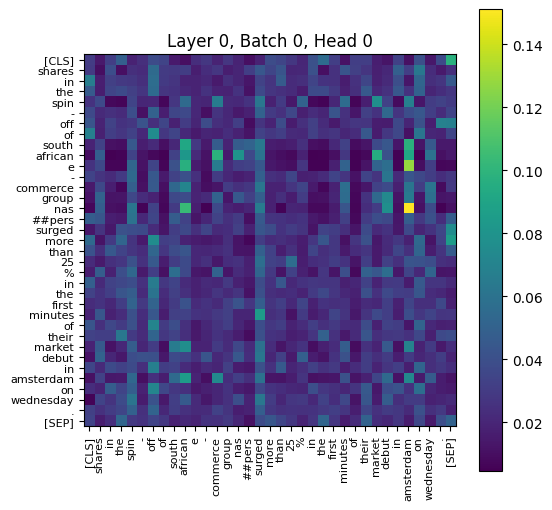

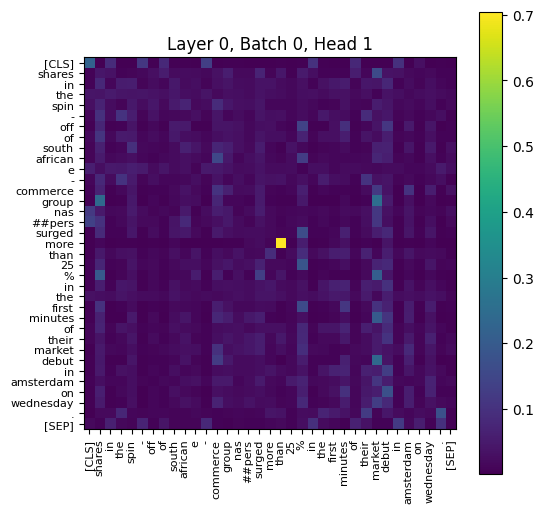

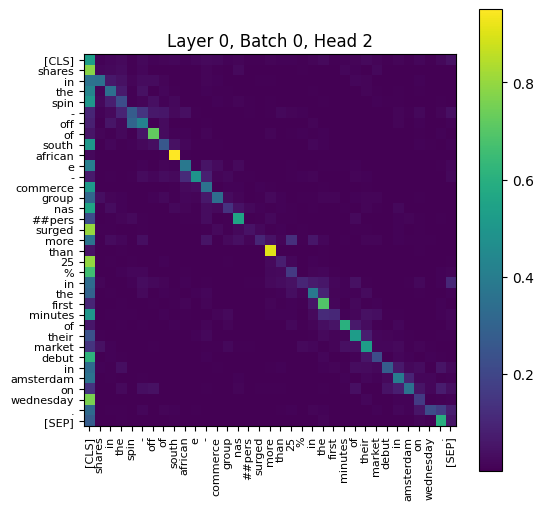

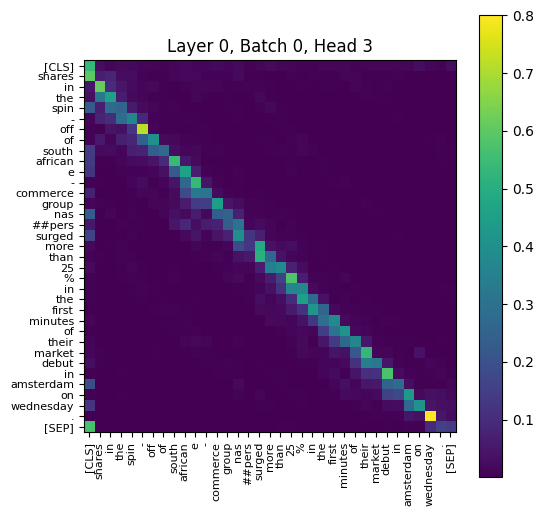

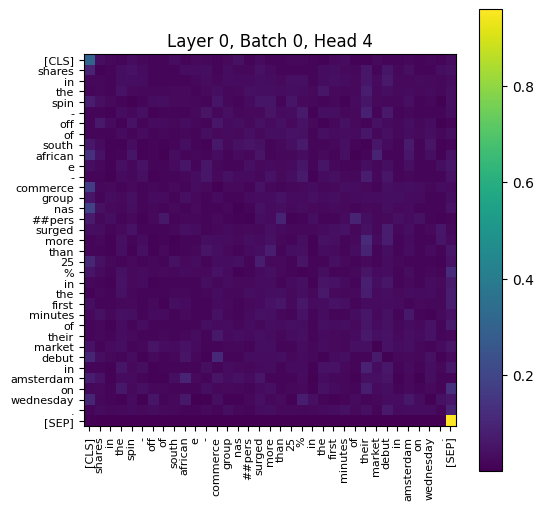

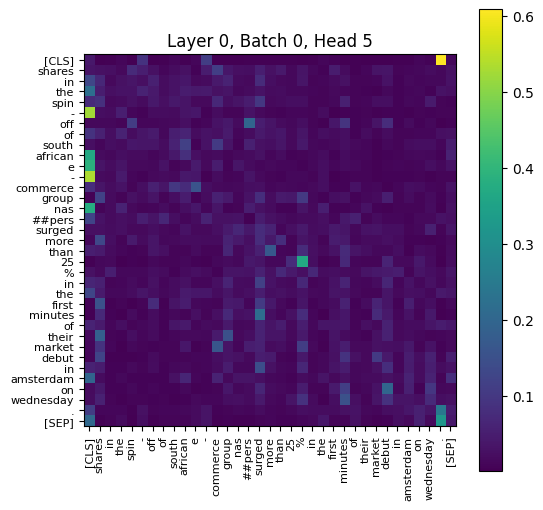

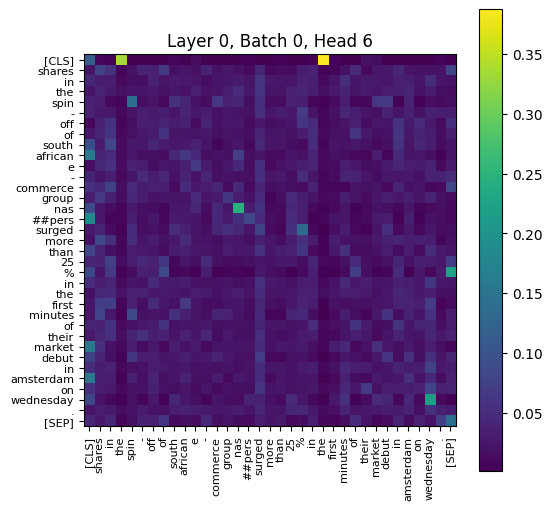

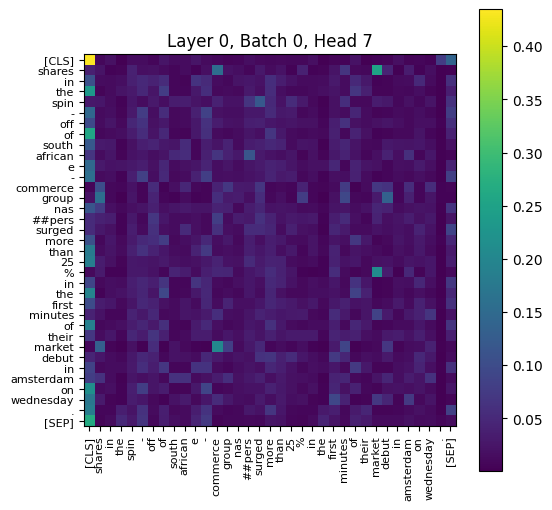

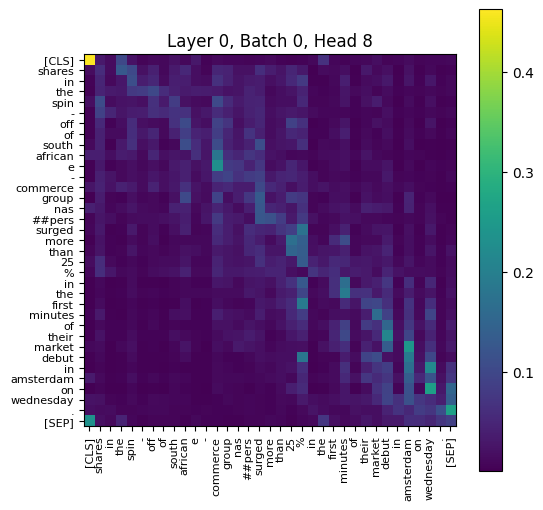

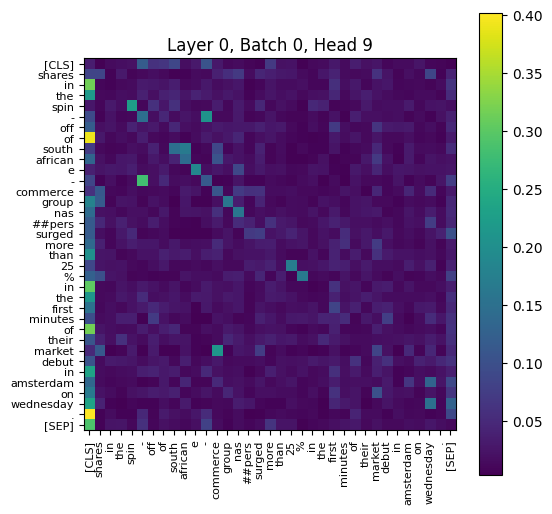

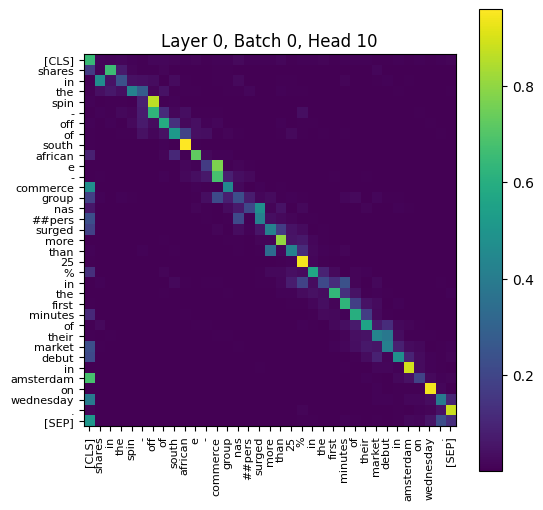

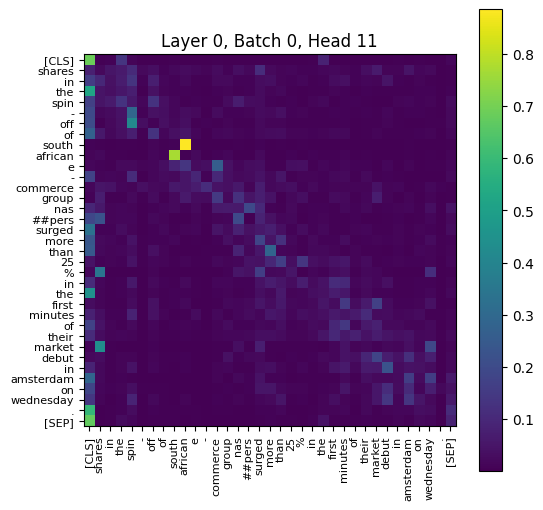

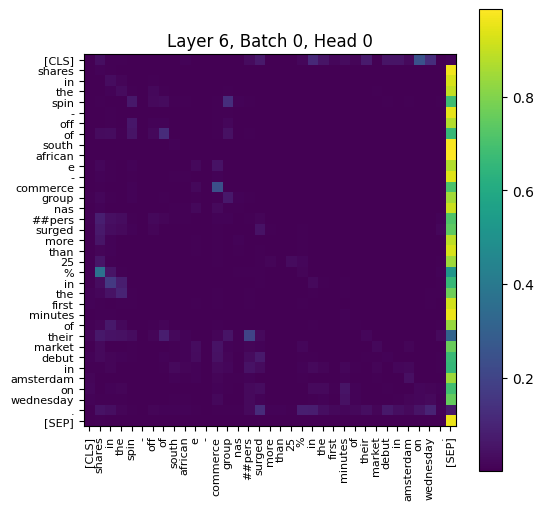

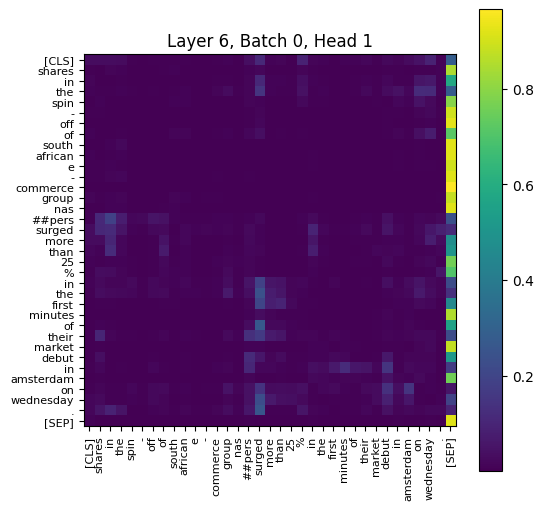

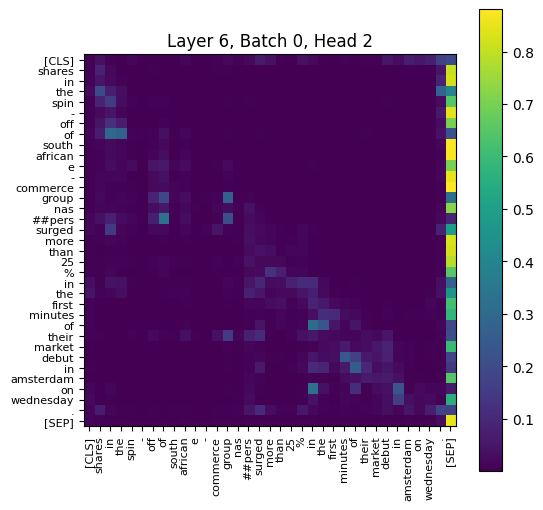

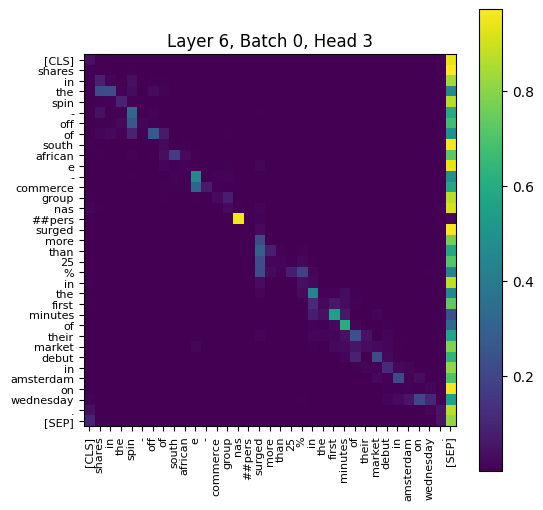

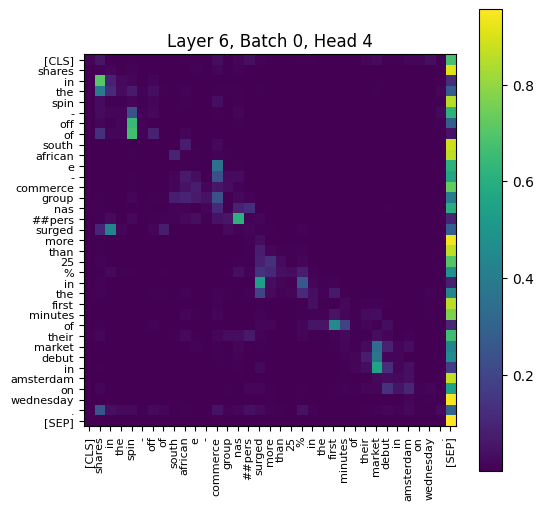

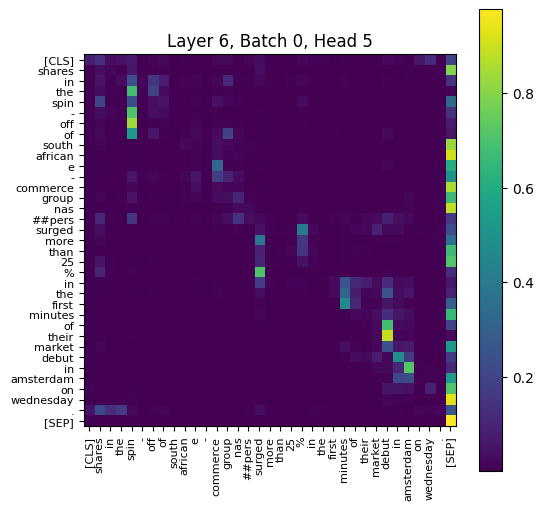

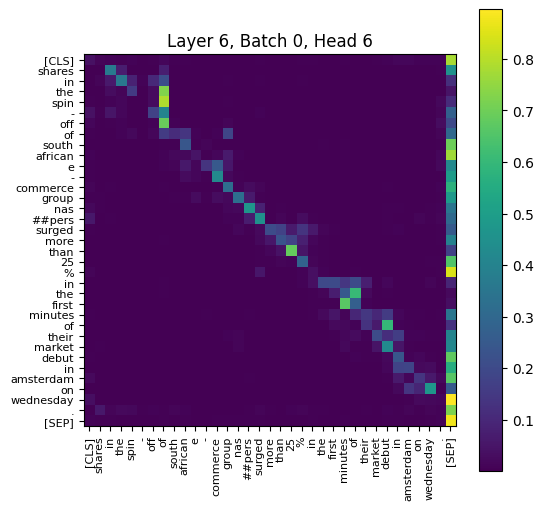

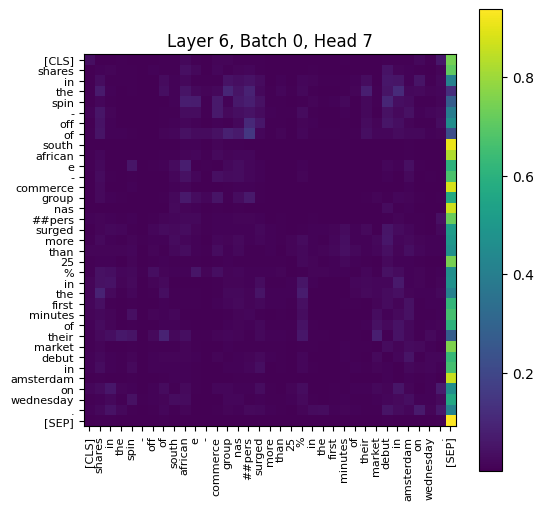

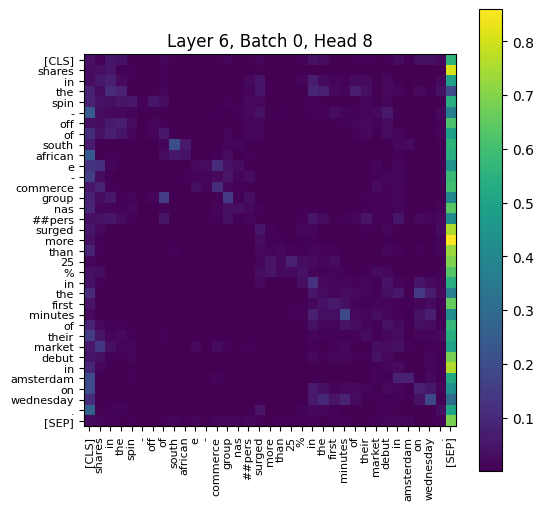

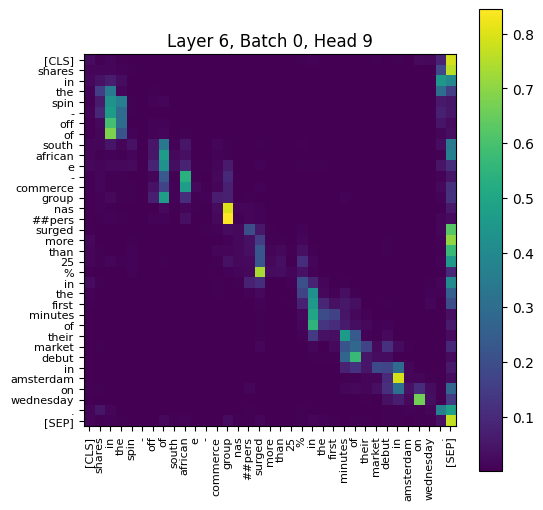

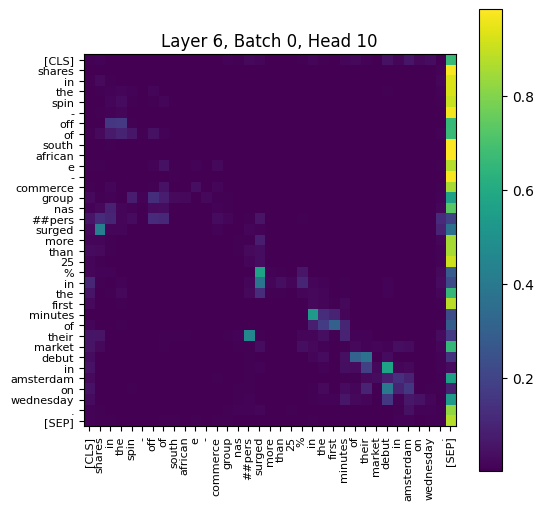

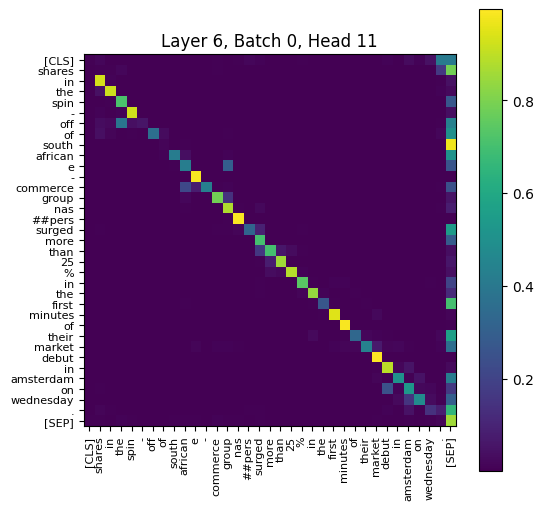

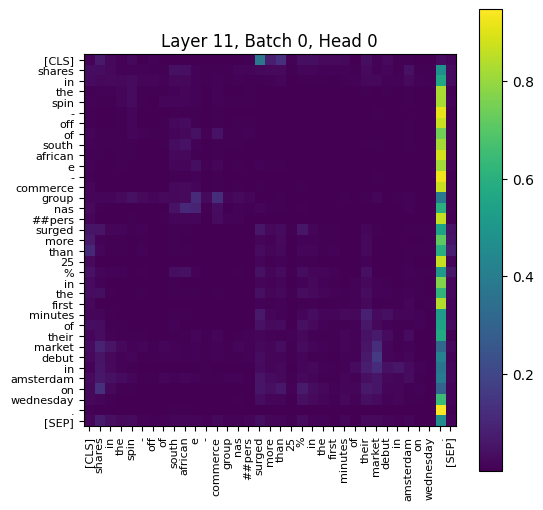

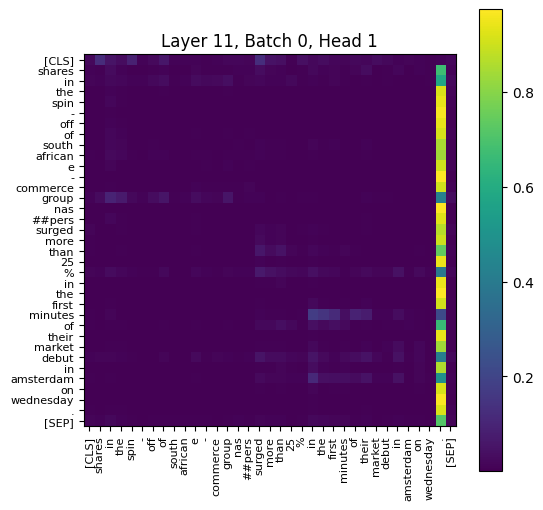

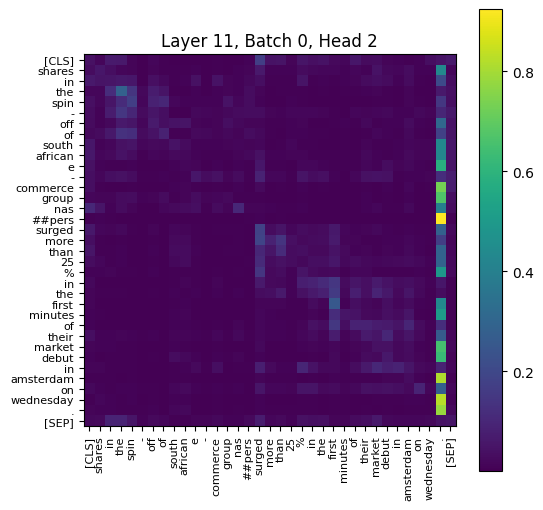

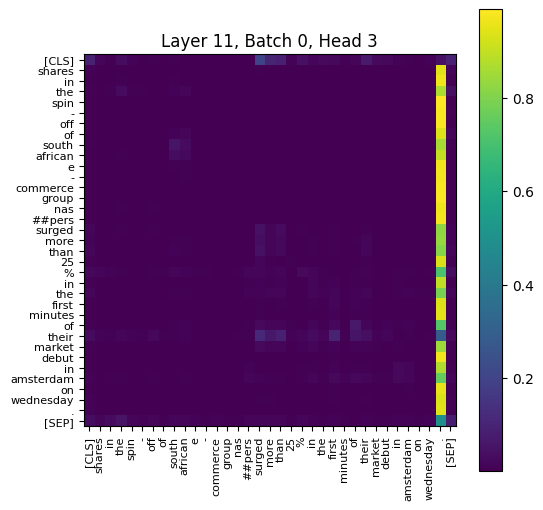

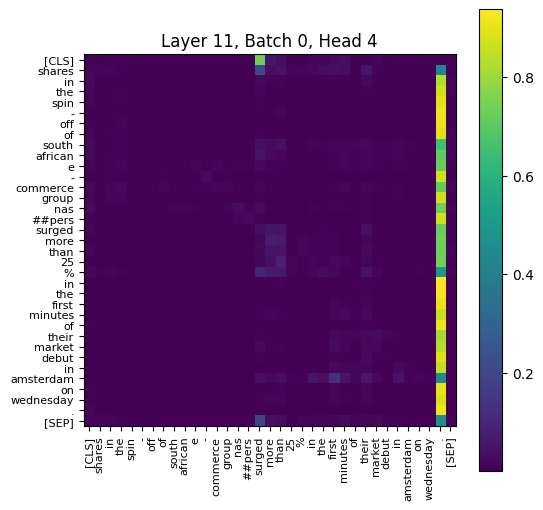

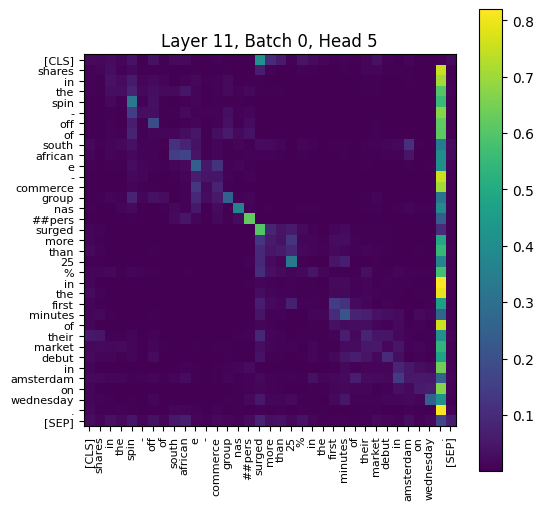

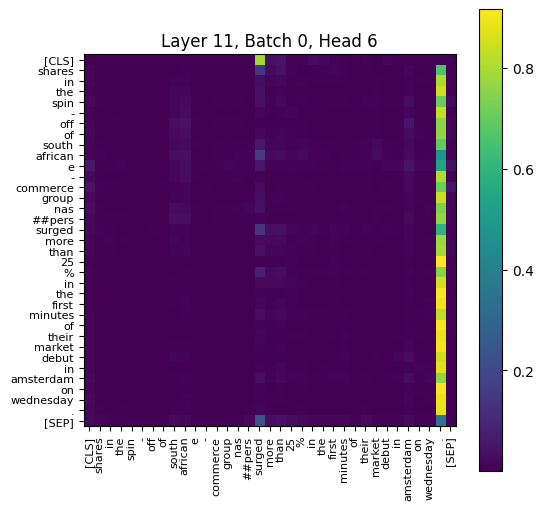

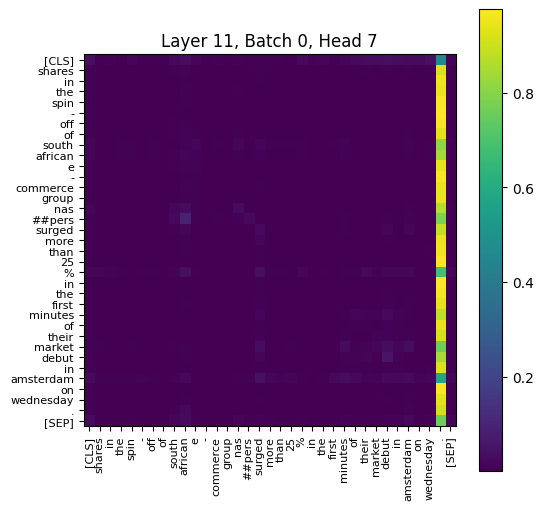

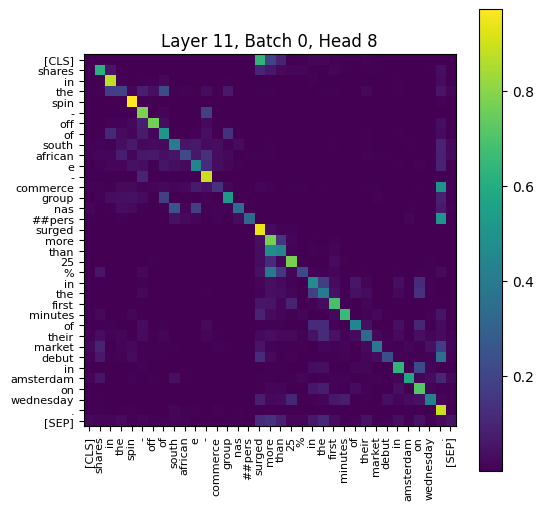

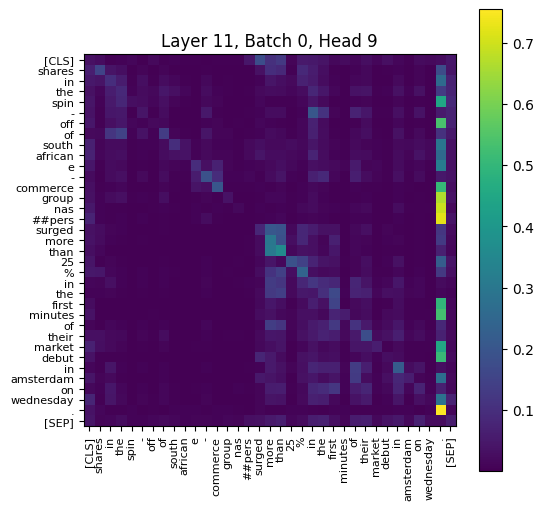

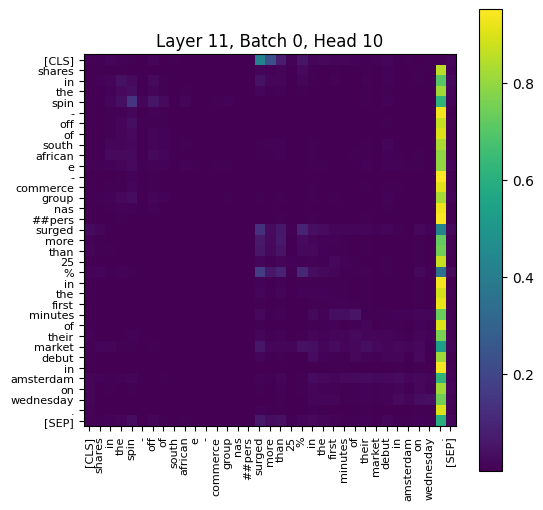

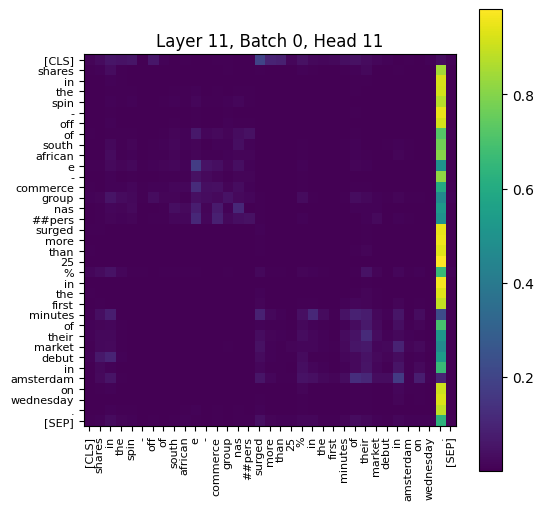

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def print_attention_matrix(attention_matrices,index_of_sample,token_ids):
  attention_matrix = attention_matrices[index_of_sample]

  tokens = tokenizer.convert_ids_to_tokens(token_ids[index_of_sample][0])
  valid_token_indices = [i for i, token in enumerate(tokens) if token != "[PAD]"]
  valid_tokens = [tokens[i] for i in valid_token_indices]
  # fixed_layer and batch_size
  batch_idx = 0

  for layer_idx in [0,6,11]:
    attention_heads = attention_matrix[layer_idx][batch_idx]  # shape: heads * seq_len * seq_len

    # Analysis attention matrix
    for head_idx, head_attention in enumerate(attention_heads):
        valid_head_attention = head_attention.cpu().numpy()[:len(valid_token_indices), :len(valid_token_indices)]

        plt.figure(figsize=(6, 6))
        plt.imshow(valid_head_attention, cmap='viridis')
        plt.xticks(ticks=range(len(valid_tokens)), labels=valid_tokens, rotation=90, fontsize=8)
        plt.yticks(ticks=range(len(valid_tokens)), labels=valid_tokens, fontsize=8)
        plt.title(f"Layer {layer_idx}, Batch {index_of_sample}, Head {head_idx}")
        plt.colorbar()
        plt.show()

print_attention_matrix(positive_attention_matrices,0,positive_token_ids)

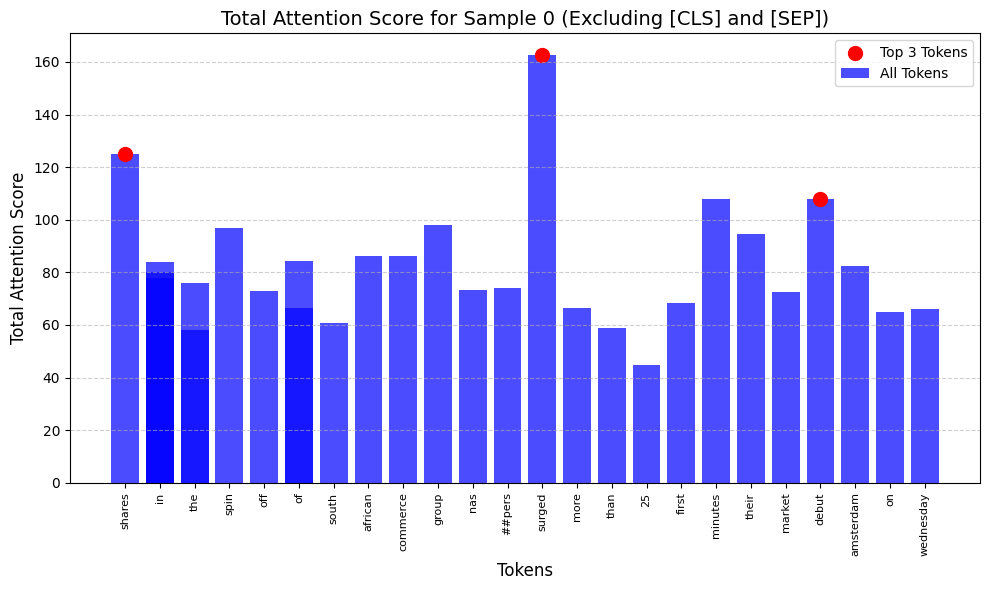

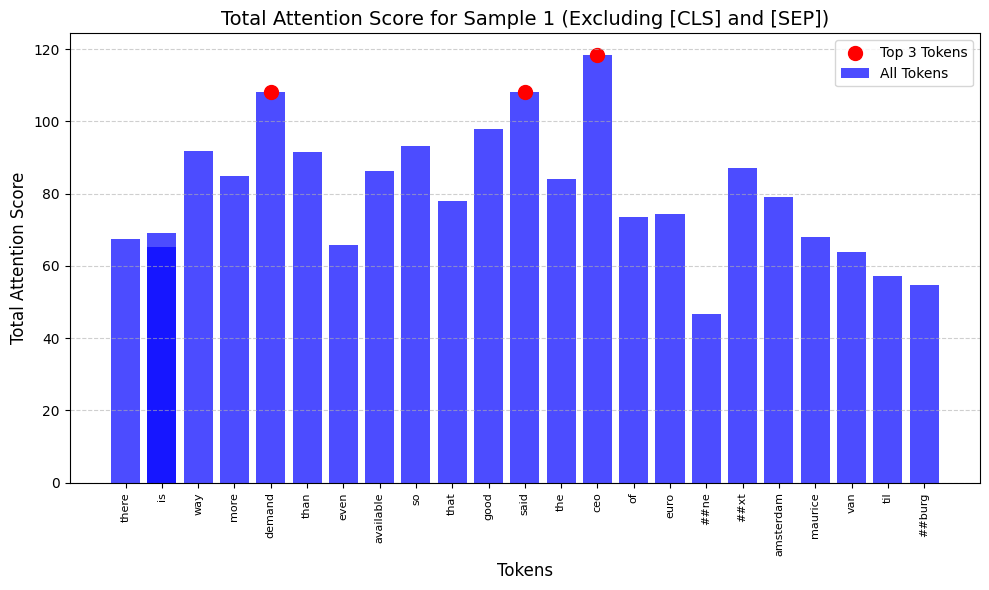

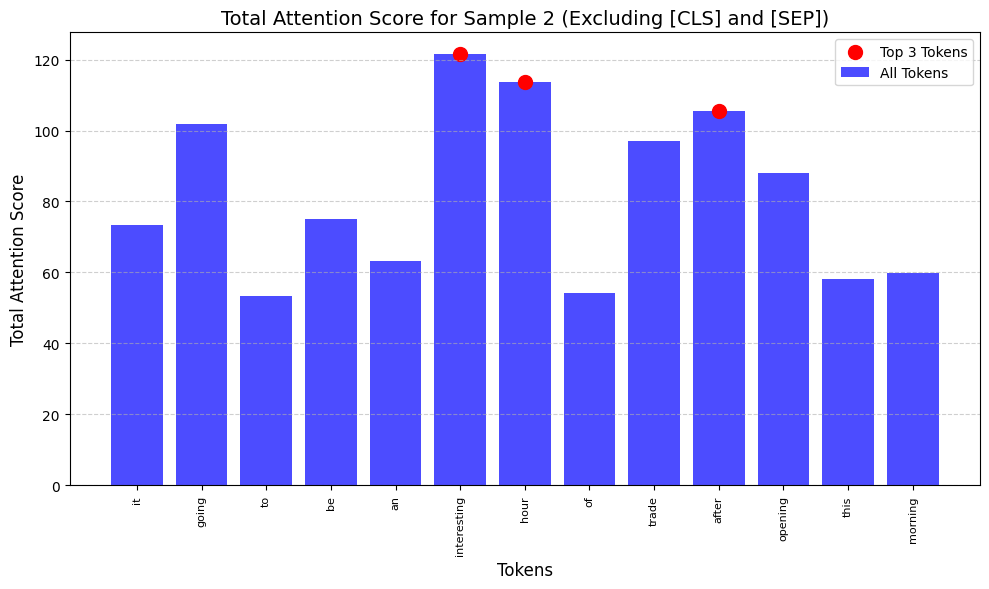

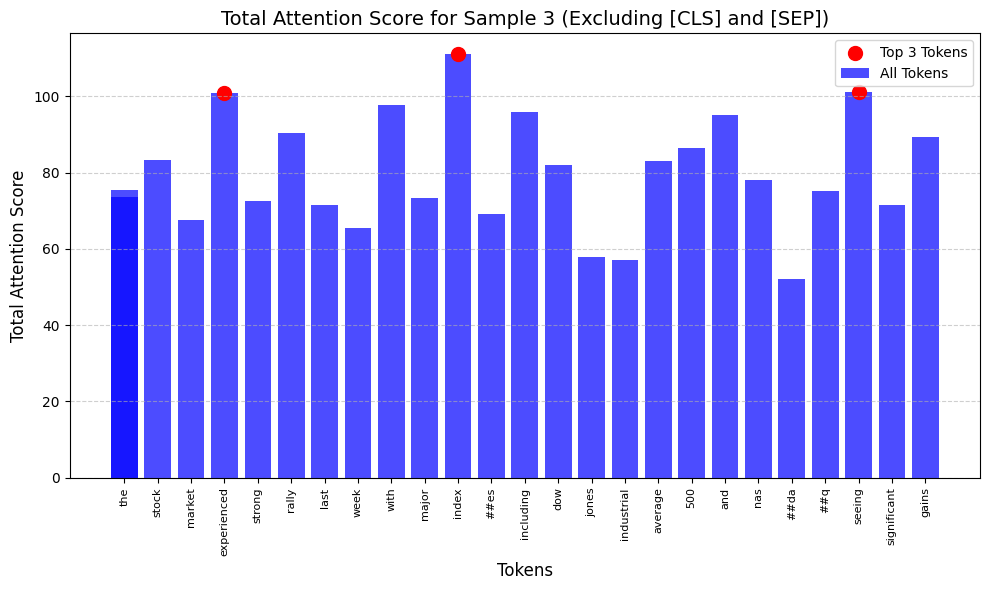

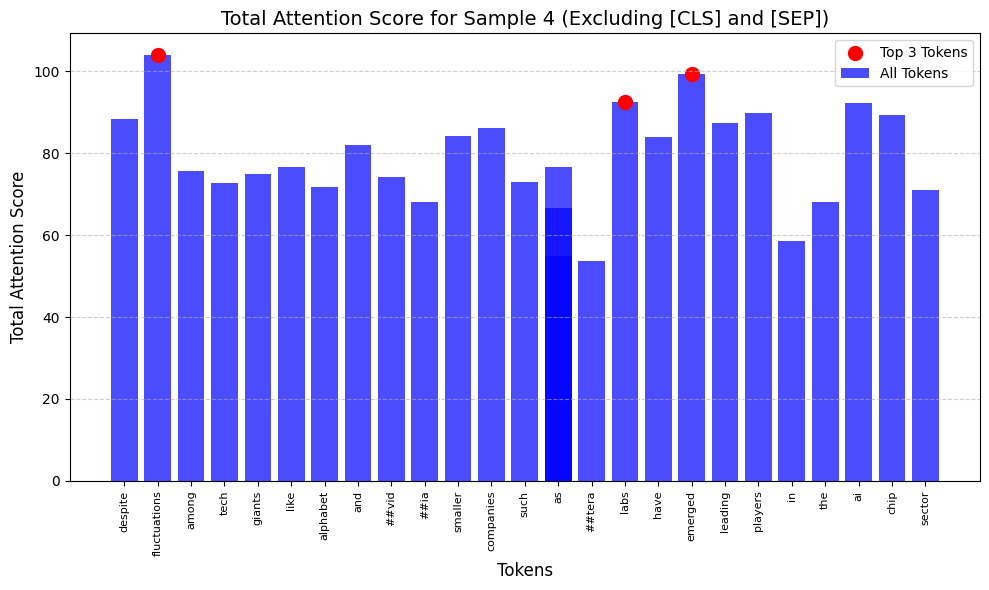

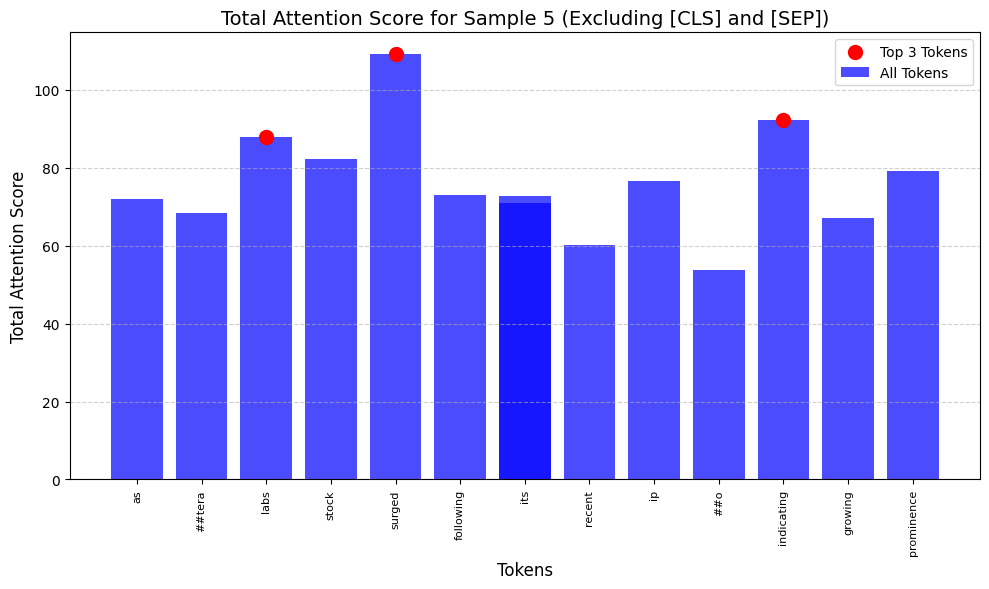

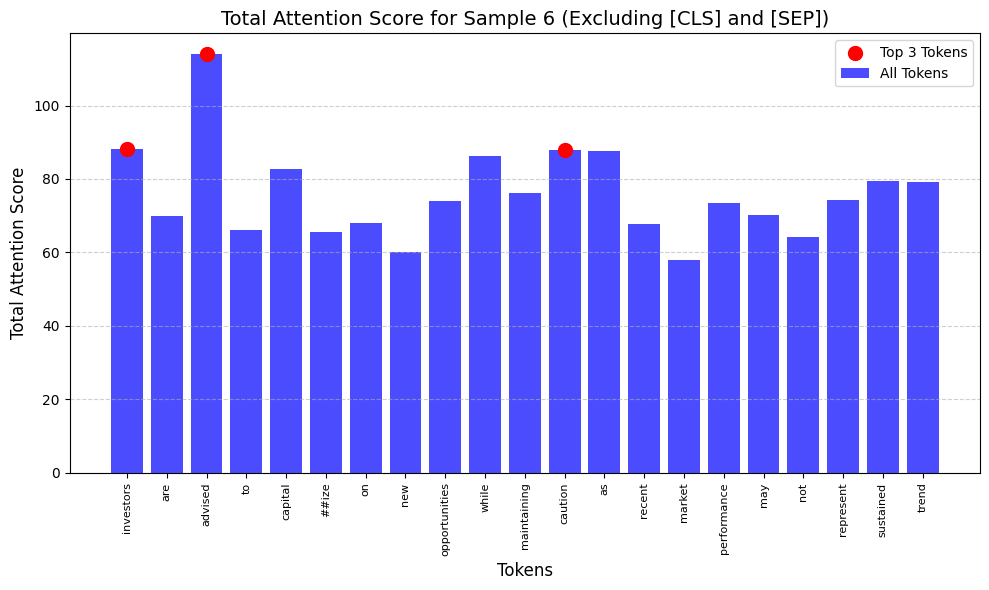

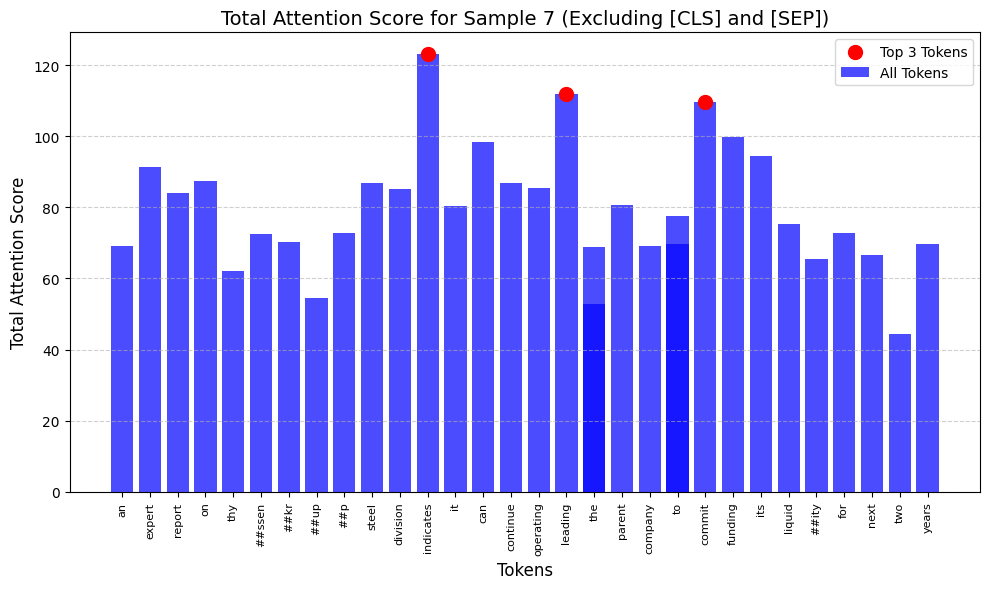

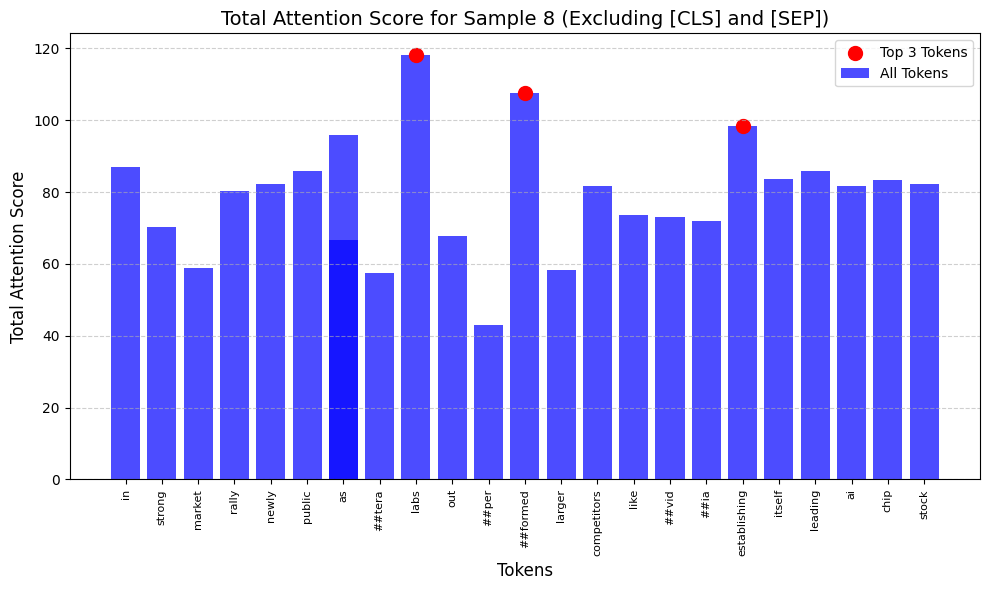

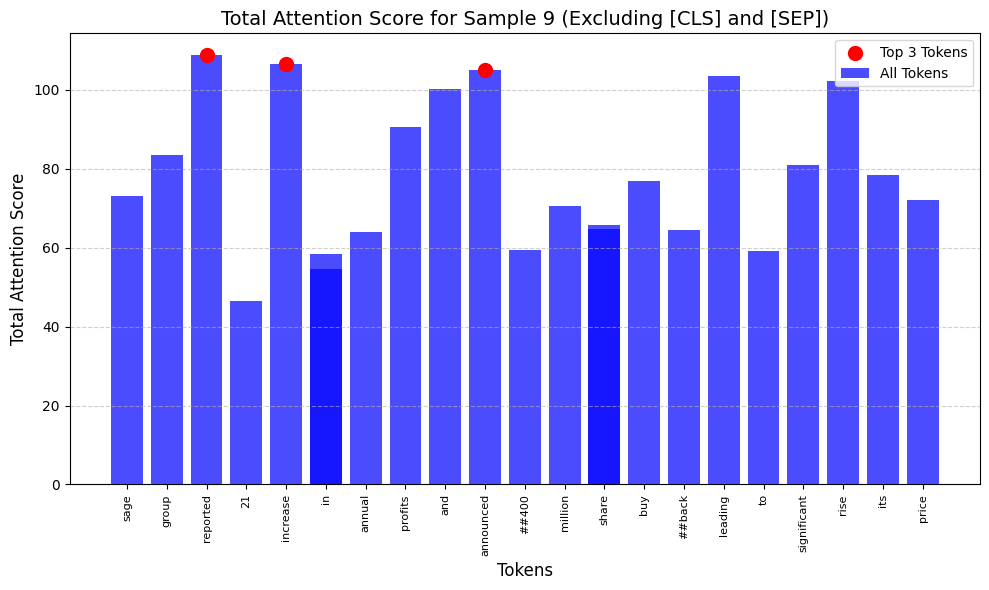

   sample_index   top_token_1     score_1 top_token_2     score_2  \
0             0        surged  162.735061      shares  124.815539   
1             1           ceo  118.475872        said  108.184221   
2             2   interesting  121.576624        hour  113.540335   
3             3         index  111.006245      seeing  101.237735   
4             4  fluctuations  104.059250     emerged   99.328293   
5             5        surged  109.333225  indicating   92.271358   
6             6       advised  113.965262   investors   88.224614   
7             7     indicates  123.052237     leading  111.938697   
8             8          labs  118.302443    ##formed  107.565546   
9             9      reported  108.904731    increase  106.602683   

    top_token_3     score_3  
0         debut  107.947751  
1        demand  108.144755  
2         after  105.416734  
3   experienced  100.797043  
4          labs   92.378754  
5          labs   87.811344  
6       caution   87.999794  


In [12]:
import pandas as pd

def calculate_all_attention_scores(attention_matrices, index_of_sample,token_ids):
    # 初始化矩阵，用于存储每个 Token 的注意力分数
    attention_matrix = attention_matrices[index_of_sample]

    tokens = tokenizer.convert_ids_to_tokens(token_ids[index_of_sample][0])
    valid_token_indices = [i for i, token in enumerate(tokens) if token != "[PAD]"]
    valid_tokens = [tokens[i] for i in valid_token_indices]

    total_attention = np.zeros((len(valid_token_indices), len(valid_token_indices)))
    batch_idx = 0

    # 累加每一层、每一个头的注意力分数
    for layer_idx in range(12):  # 假设有 12 层
        attention_heads = attention_matrix[layer_idx][batch_idx]  # shape: heads * seq_len * seq_len

        for head_idx, head_attention in enumerate(attention_heads):
            # 提取有效 Token 的注意力矩阵
            valid_head_attention = head_attention.cpu().numpy()[:len(valid_token_indices), :len(valid_token_indices)]
            total_attention += valid_head_attention  # 累加到总注意力矩阵

    # 计算每个 Token 的总注意力分数（按列求和）
    token_attention_scores = total_attention.sum(axis=0)

    # 过滤掉 [CLS]、[SEP] 和单字符 Token
    filtered_tokens = []
    filtered_scores = []

    for token, score in zip(valid_tokens, token_attention_scores):
        if token not in ["[CLS]", "[SEP]"] and len(token) > 1:
            filtered_tokens.append(token)
            filtered_scores.append(score)

    # 获取分数最高的三个 Token
    top_three_indices = np.argsort(filtered_scores)[-3:][::-1]  # 获取最高的三个分数的索引
    top_tokens = [filtered_tokens[i] for i in top_three_indices]
    top_scores = [filtered_scores[i] for i in top_three_indices]

    # 绘制注意力分数分布图
    plt.figure(figsize=(10, 6))
    plt.bar(filtered_tokens, filtered_scores, color='blue', alpha=0.7, label="All Tokens")
    plt.scatter([filtered_tokens[i] for i in top_three_indices],
                [filtered_scores[i] for i in top_three_indices],
                color='red', s=100, label="Top 3 Tokens")  # 标注最高的 3 个
    plt.xlabel("Tokens", fontsize=12)
    plt.ylabel("Total Attention Score", fontsize=12)
    plt.title(f"Total Attention Score for Sample {index_of_sample} (Excluding [CLS] and [SEP])", fontsize=14)
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 返回结果
    return {
        "sample_index": index_of_sample,
        "top_token_1": top_tokens[0],
        "score_1": top_scores[0],
        "top_token_2": top_tokens[1],
        "score_2": top_scores[1],
        "top_token_3": top_tokens[2],
        "score_3": top_scores[2],
    }

# 初始化 DataFrame
positive_results = []

# 迭代所有样本并存储结果，同时绘图
for i in range(len(positive_result)):
    positive_result_row = calculate_all_attention_scores(positive_attention_matrices, i,positive_token_ids)
    positive_results.append(positive_result_row)

# 转换为 pandas DataFrame
df_positive_results = pd.DataFrame(positive_results)


# 打印 DataFrame
print(df_positive_results)


#### Negative Part

In [13]:
negative_text = """Indian billionaire Gautam Adani and his nephew have been indicted by U.S. prosecutors for their roles in a $265 million bribery scheme to secure power-supply deals in India. This scandal has led to a significant financial fallout for the Adani Group, wiping billions off its market value and prompting Kenya to cancel a major airport project with the conglomerate.
KMD Brands, owner of Kathmandu, Rip Curl, and Oboz, is experiencing a significant sales decline across its brands, putting pressure on margins and profits for the first half of 2025. A trading update revealed a decrease in sales for its adventurewear chain Kathmandu by 2.7%, Rip Curl by 6.7%, and Oboz by 8.6% between August 24 and October 24, leading to an overall group sales drop of 5.8% for the first quarter.
The rapid decline in used-car prices has left many drivers in financial risk, with roughly a third of those who financed their vehicles having negative equity. This means their loan balances exceed their car's value, exacerbated by a 19% drop in used car prices since their peak in 2022.
Moody's has downgraded Mexico's government debt outlook from "stable" to "negative," citing a weakening judicial system due to newly approved laws and increased government debt.
Victorian hospitals are facing a financial crisis, recording over $1 billion in deficits for the 2023-24 financial year. The most affected include Monash Health with a $321 million deficit and Northern Health at $115 million. Financial strain is attributed to growing demand and challenges in funding models.
"""

negative_result,negative_attention_matrices,negative_token_ids = predict(negative_text,model)

<ipython-input-5-0c8242d21fa0>:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, batch_result], ignore_index=True)


In [14]:
negative_result

sentence  \
0  Indian billionaire Gautam Adani and his nephew...   
1  This scandal has led to a significant financia...   
2  KMD Brands, owner of Kathmandu, Rip Curl, and ...   
3  A trading update revealed a decrease in sales ...   
4  The rapid decline in used-car prices has left ...   
5  This means their loan balances exceed their ca...   
6  Moody's has downgraded Mexico's government deb...   
7  Victorian hospitals are facing a financial cri...   
8  The most affected include Monash Health with a...   
9  Financial strain is attributed to growing dema...   

                                    logit prediction  sentiment_score  
0   [0.040353637, 0.75413144, 0.20551498]   negative        -0.713778  
1   [0.01104552, 0.95773333, 0.031221097]   negative        -0.946688  
2   [0.007561856, 0.9746912, 0.017746907]   negative        -0.967129  
3  [0.0071395417, 0.9757499, 0.017110586]   negative        -0.968610  
4  [0.008658066, 0.96985406, 0.021487903]   negative        -0.961196  
5   [0.021034522, 0.9680416, 0.010923873]   negative        -0.947007  
6    [0.009929116, 0.9698387, 0.02023223]   negative        -0.959910  
7   [0.008779915, 0.9707546, 0.020465512]   negative        -0.961975  
8  [0.007951271, 0.95769864, 0.034350056]   negative        -0.949747  
9  [0.011698824, 0.94573927, 0.042561896]   negative        -0.934040

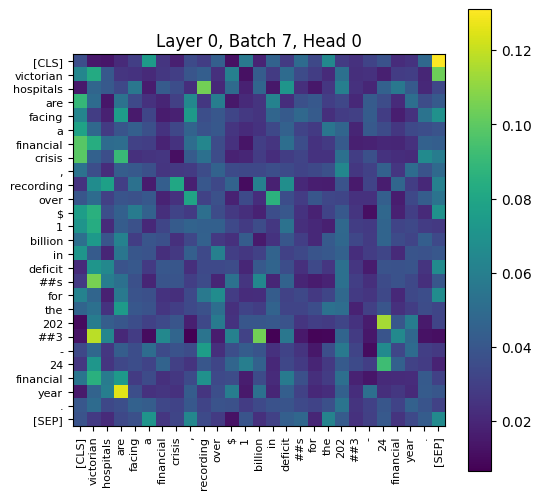

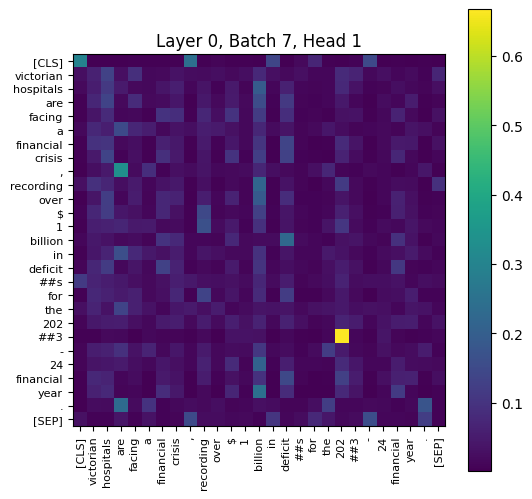

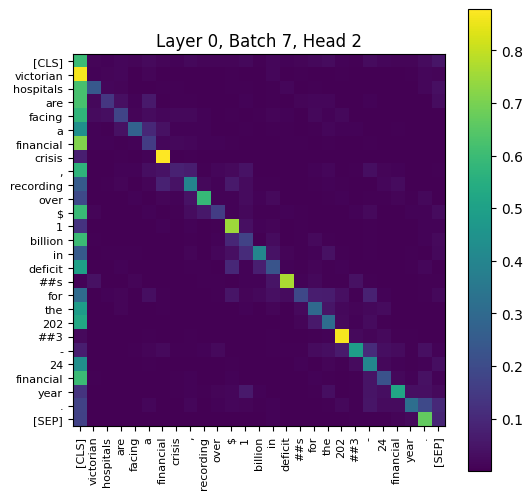

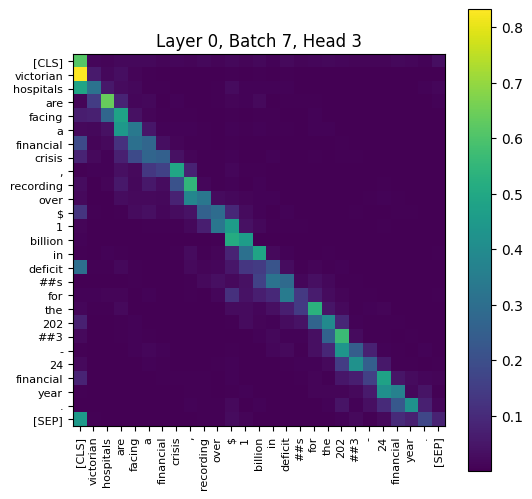

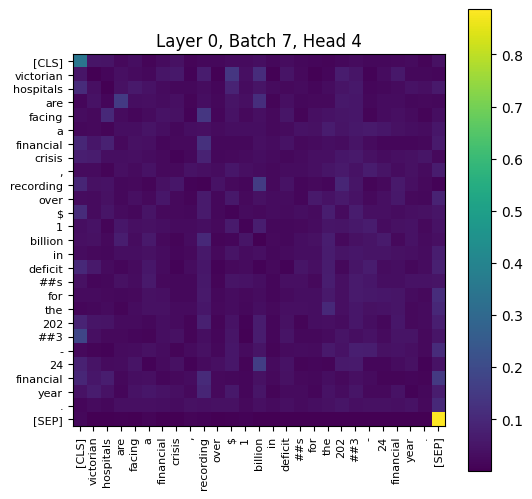

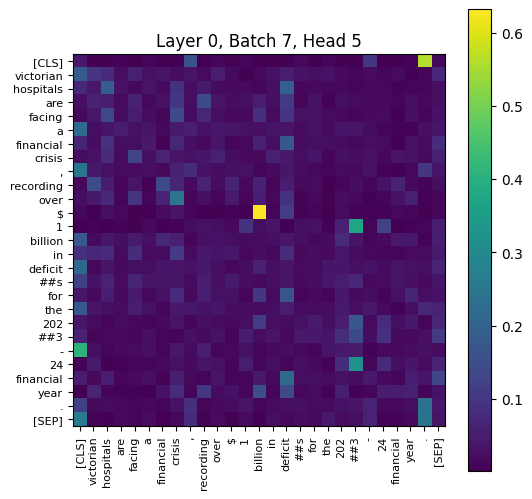

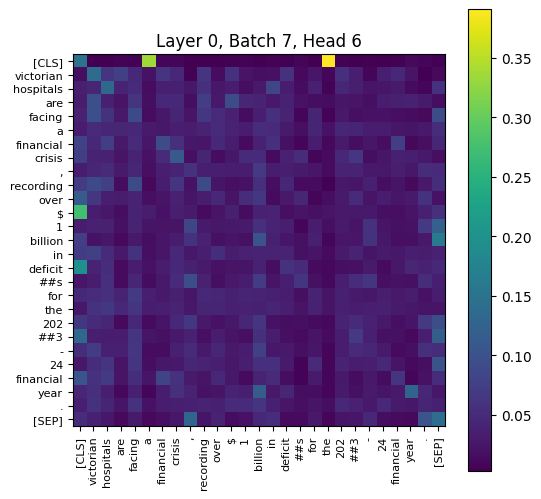

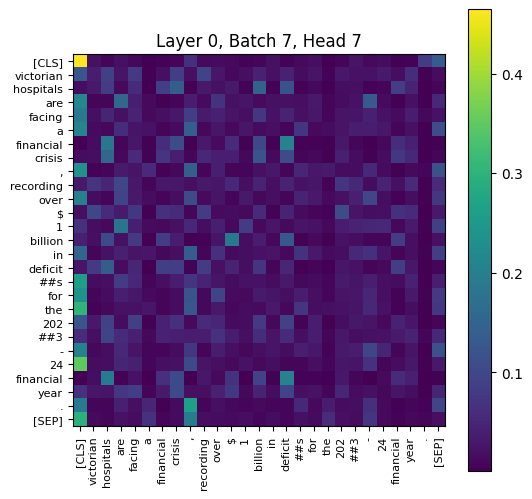

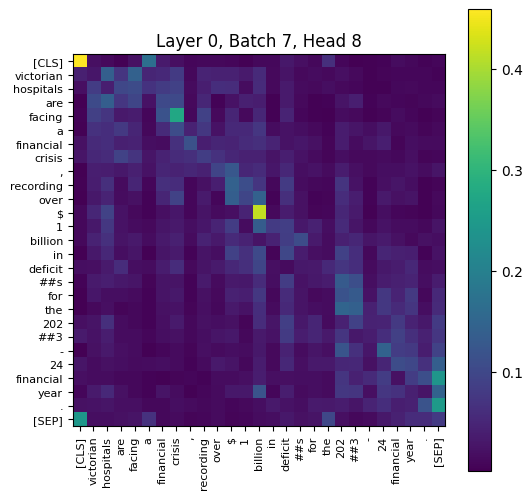

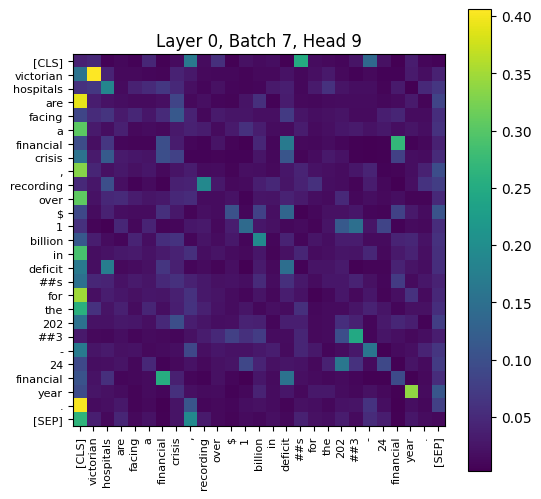

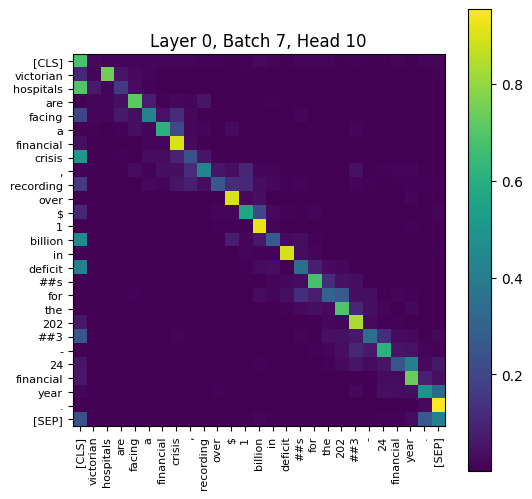

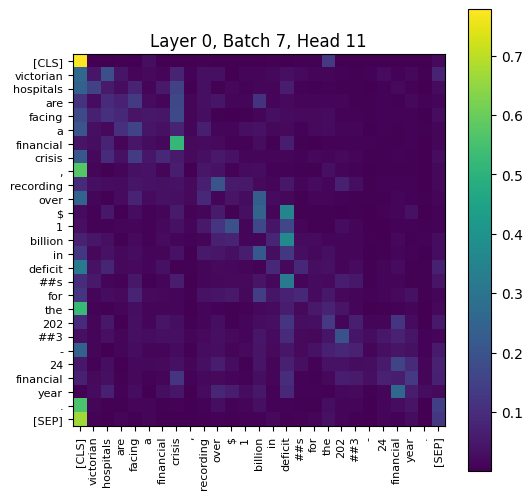

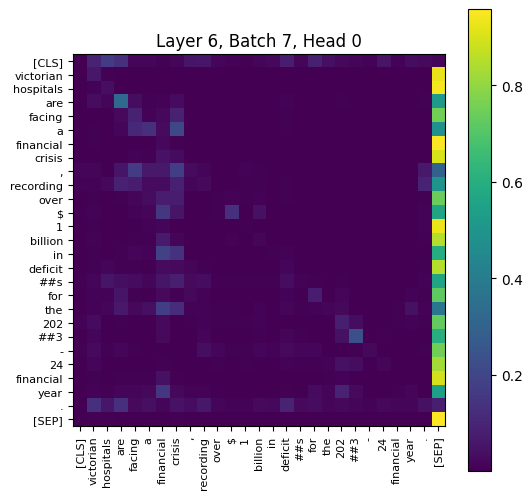

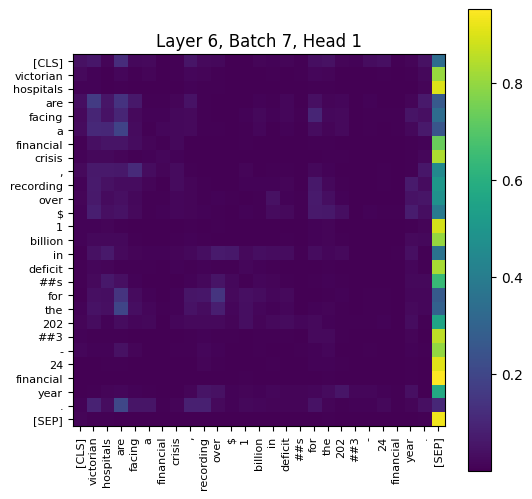

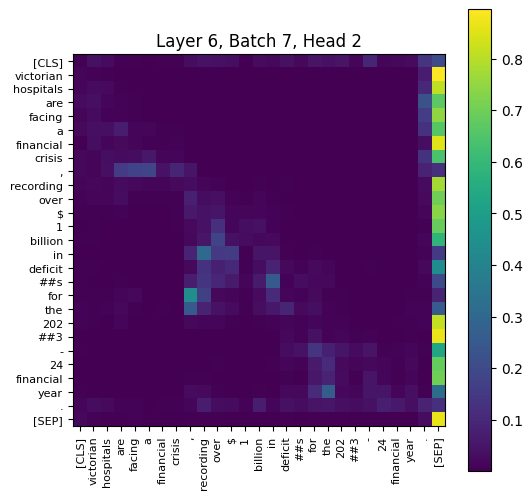

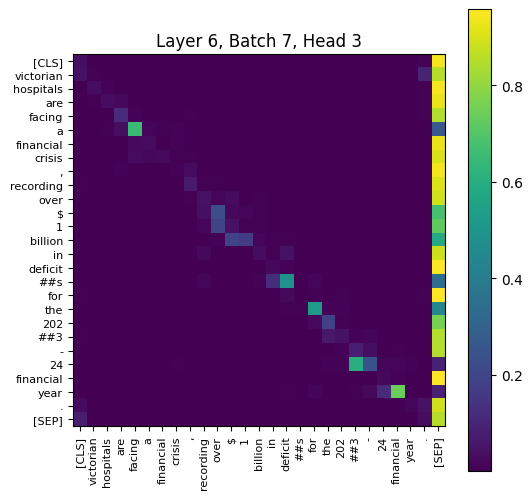

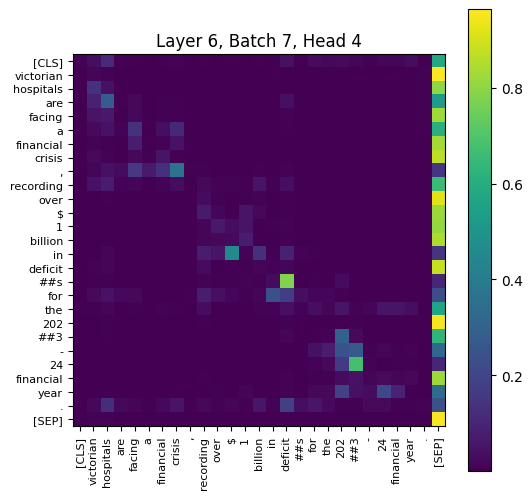

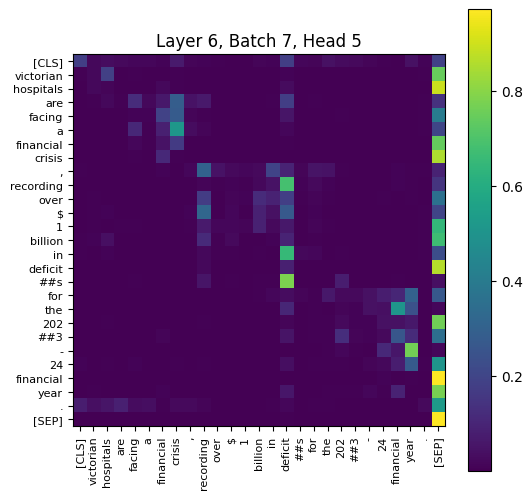

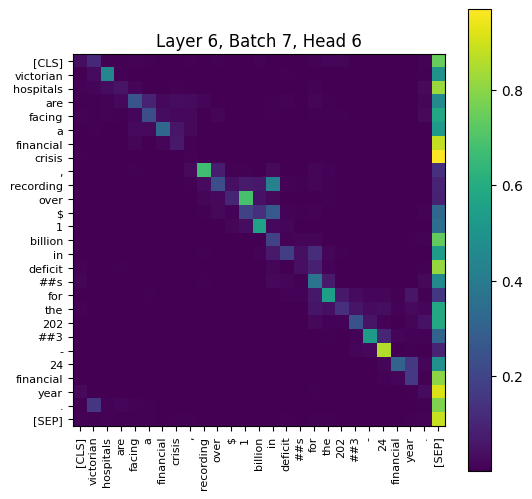

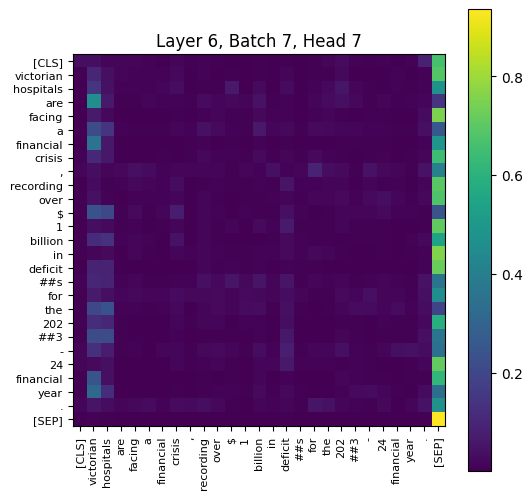

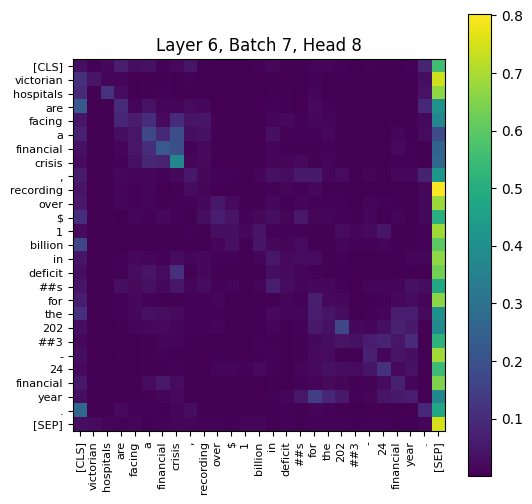

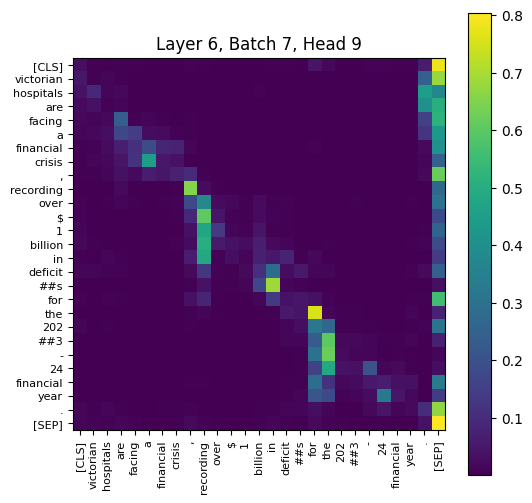

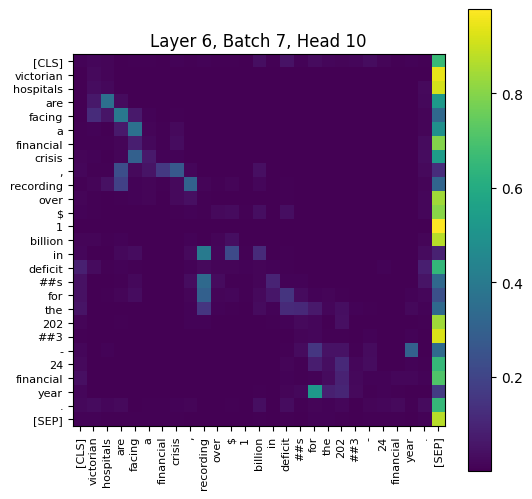

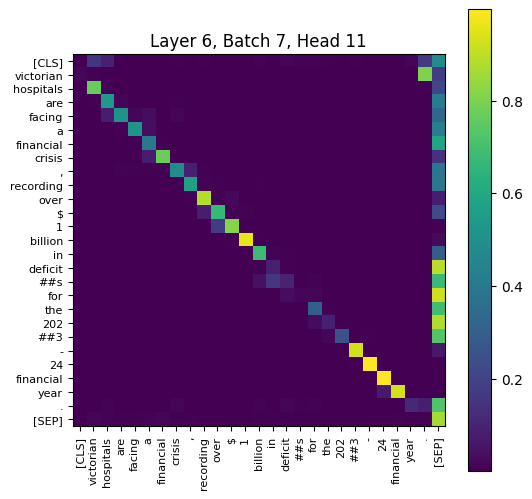

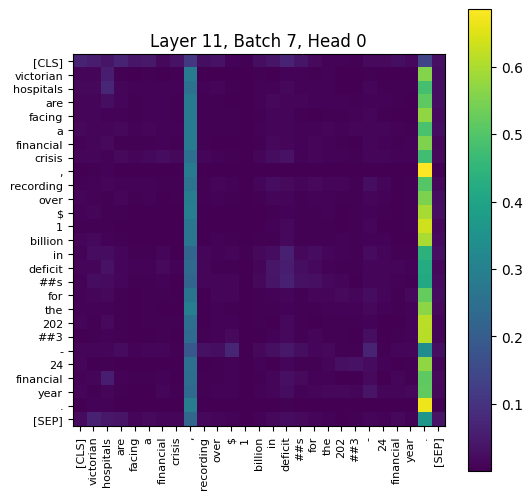

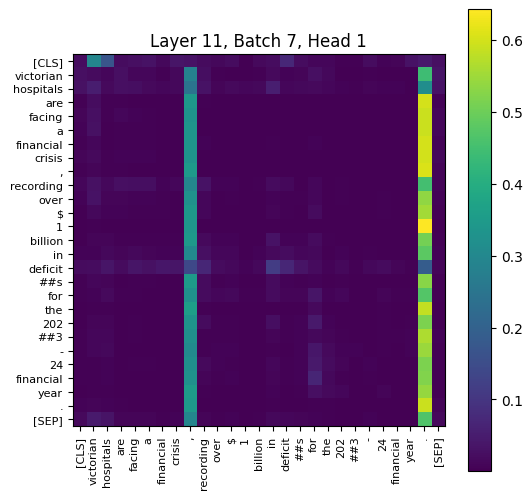

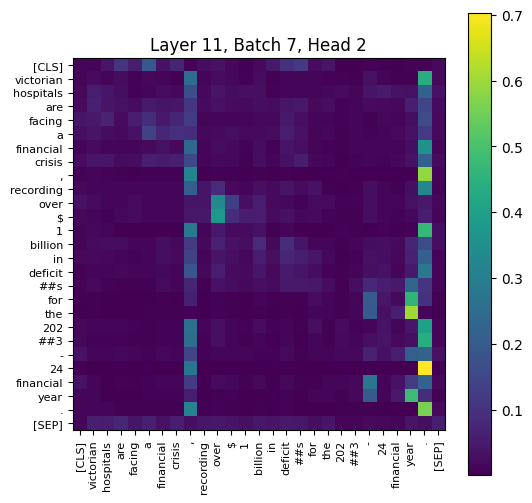

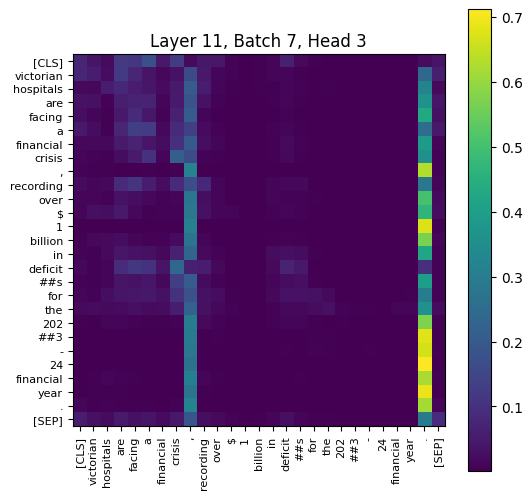

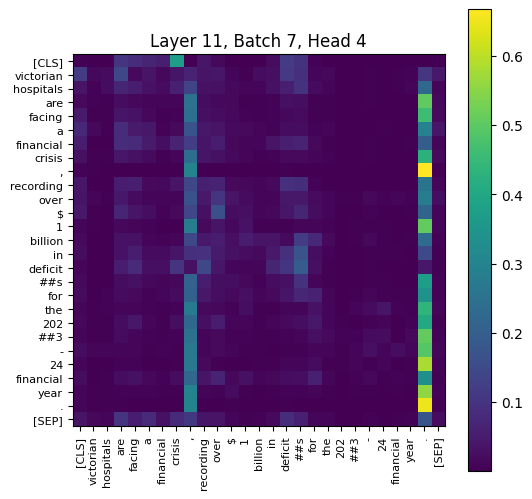

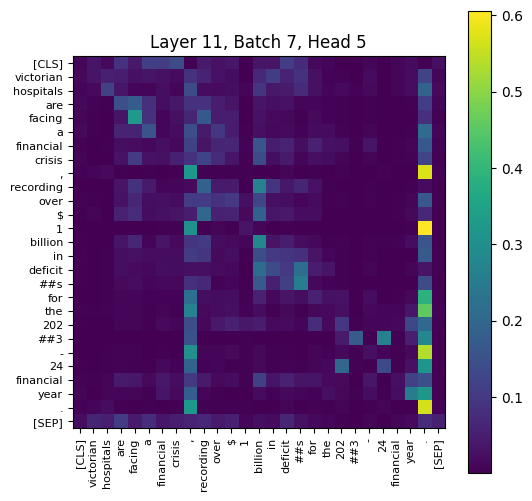

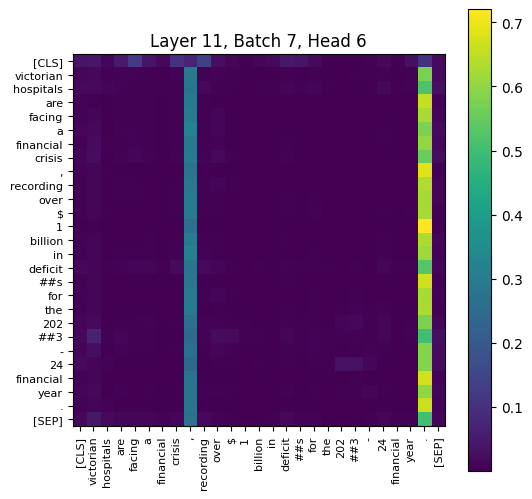

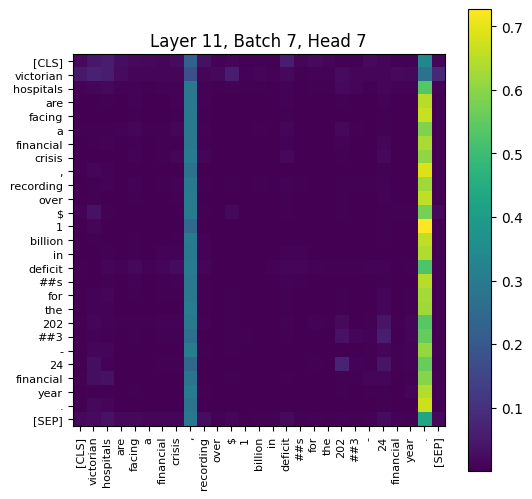

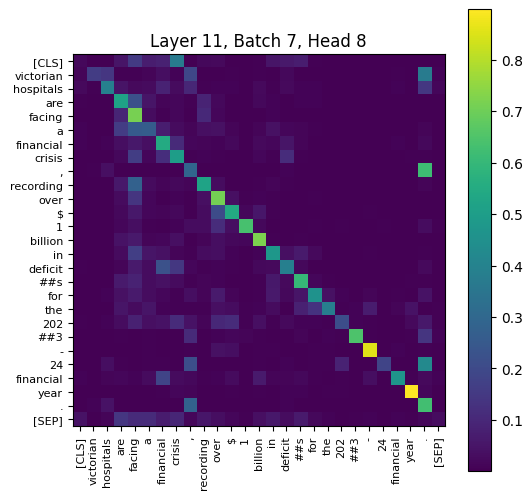

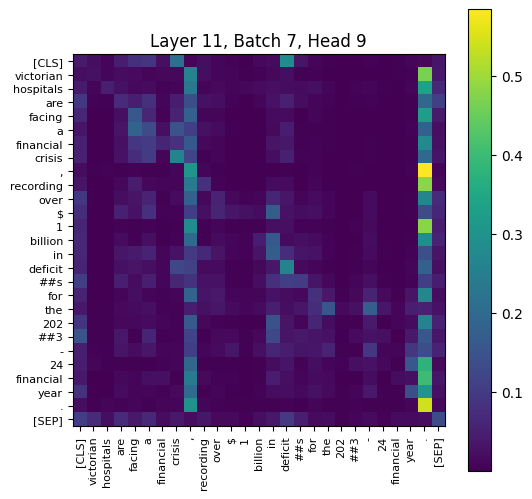

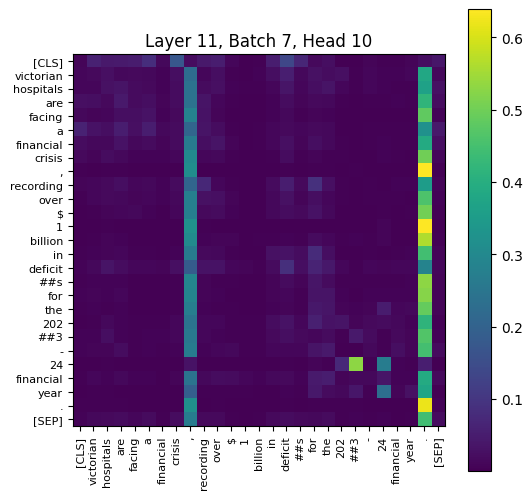

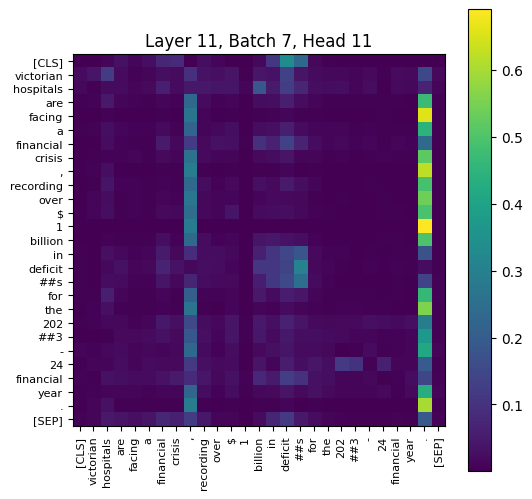

In [15]:
print_attention_matrix(negative_attention_matrices,7,negative_token_ids)

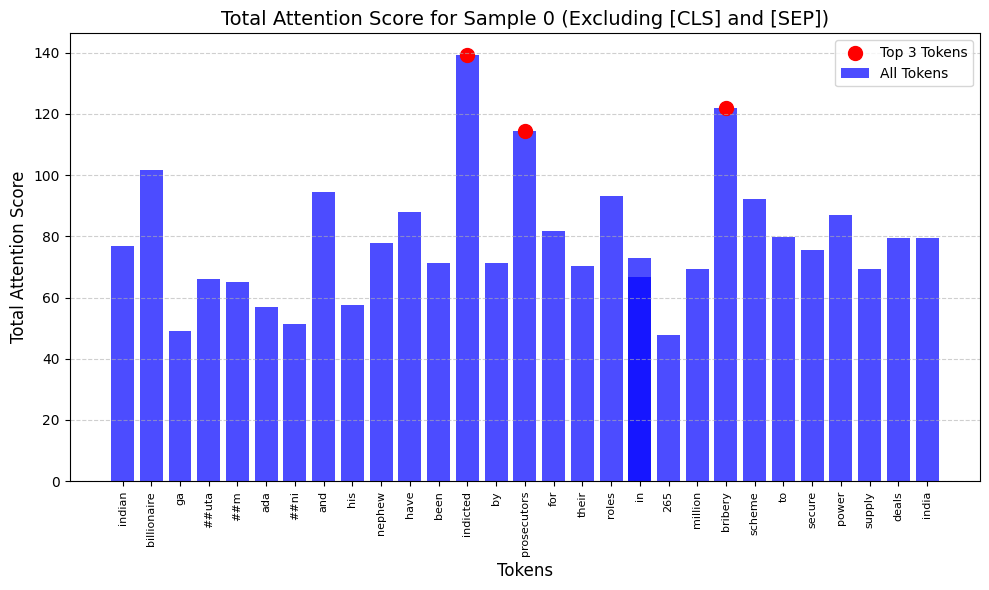

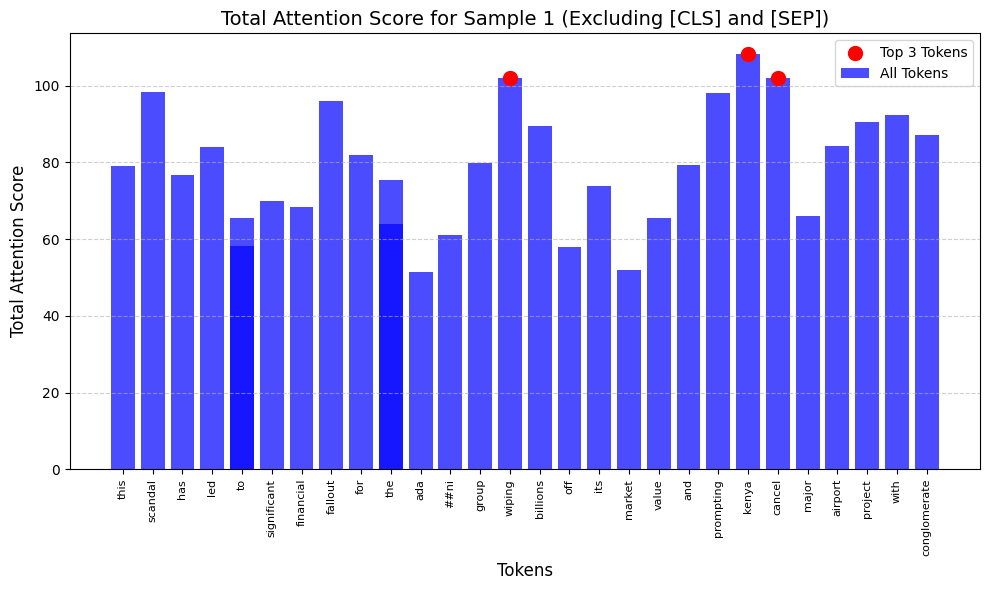

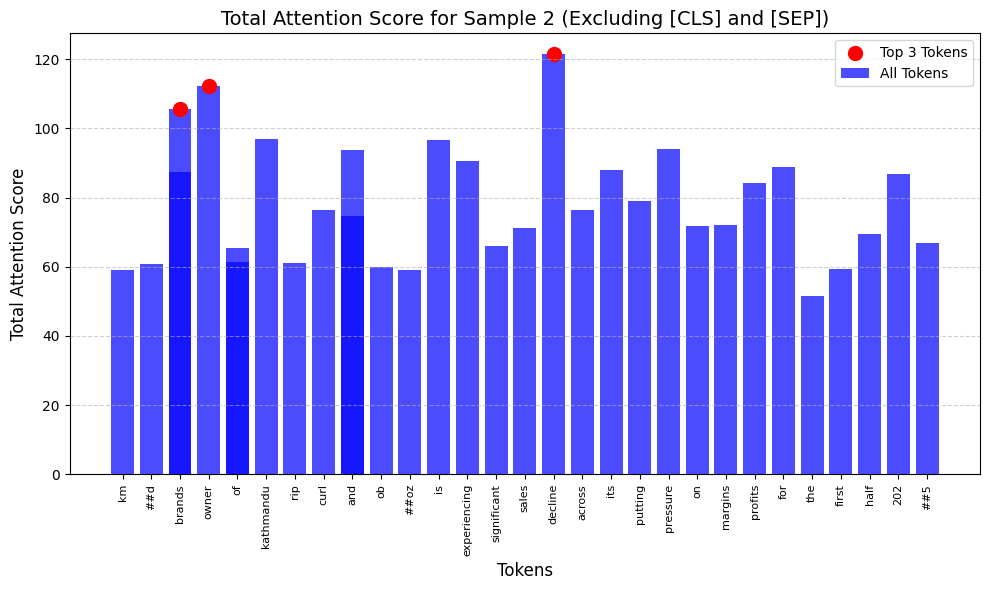

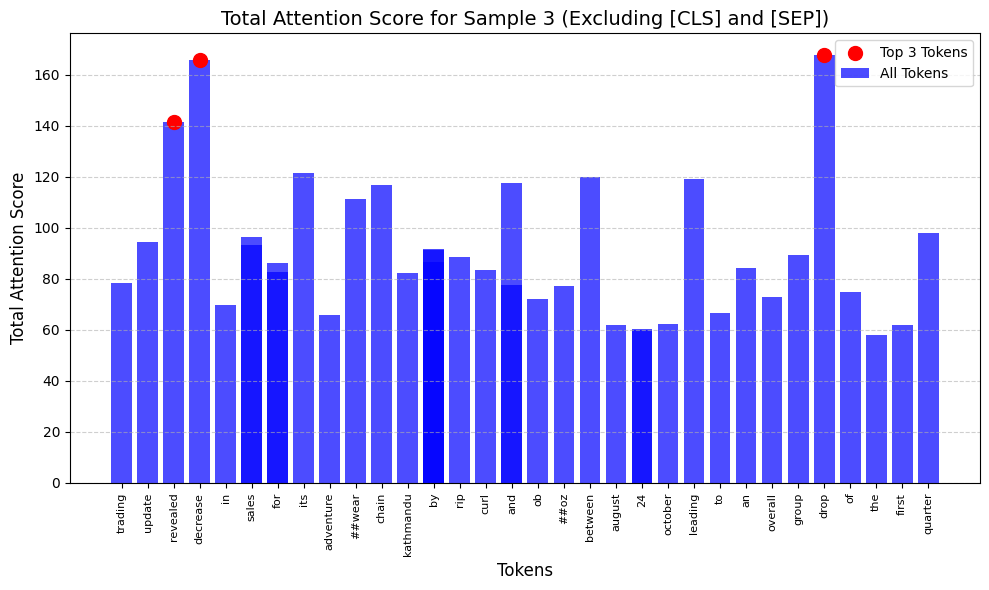

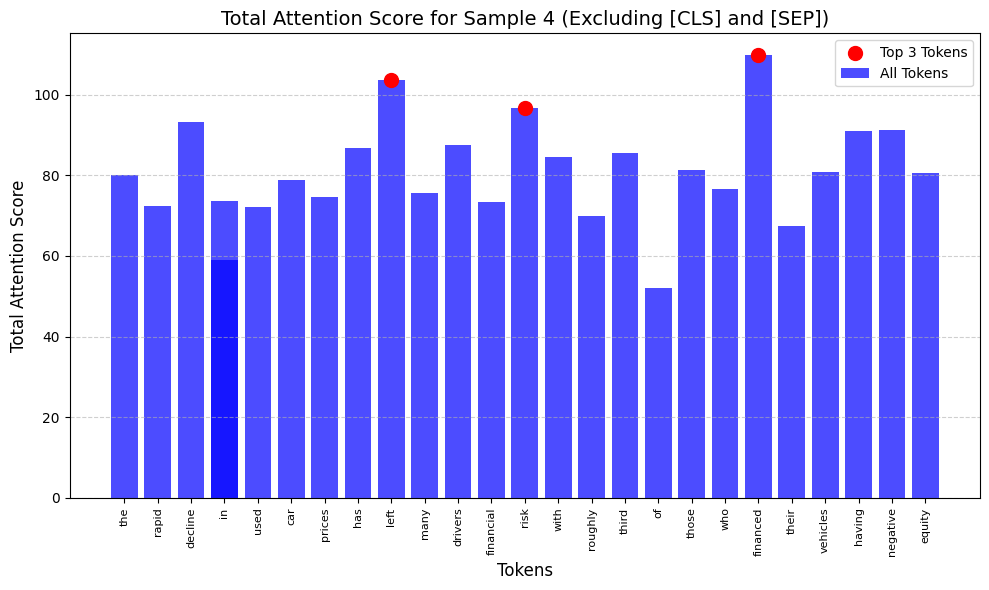

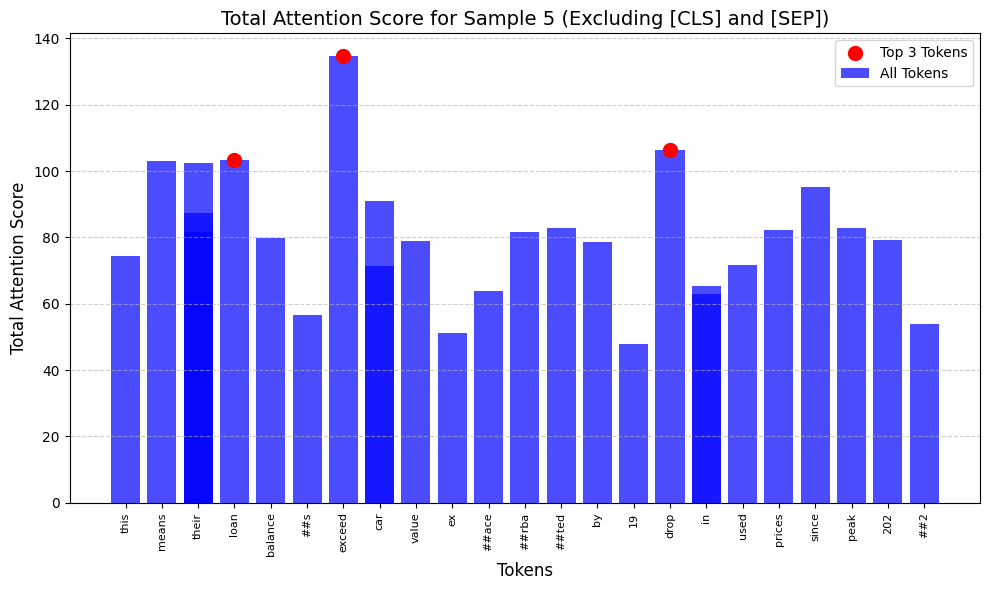

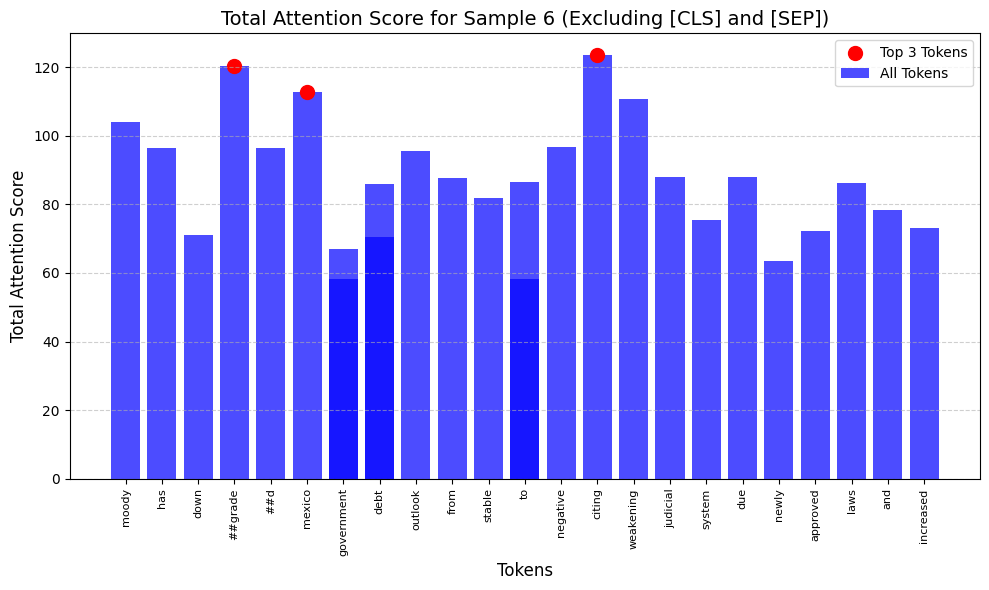

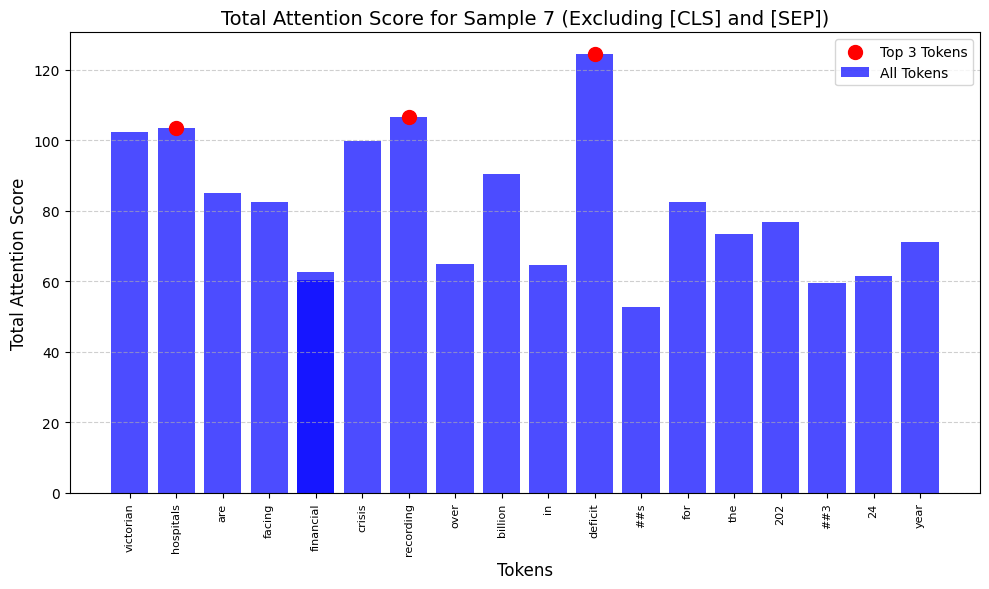

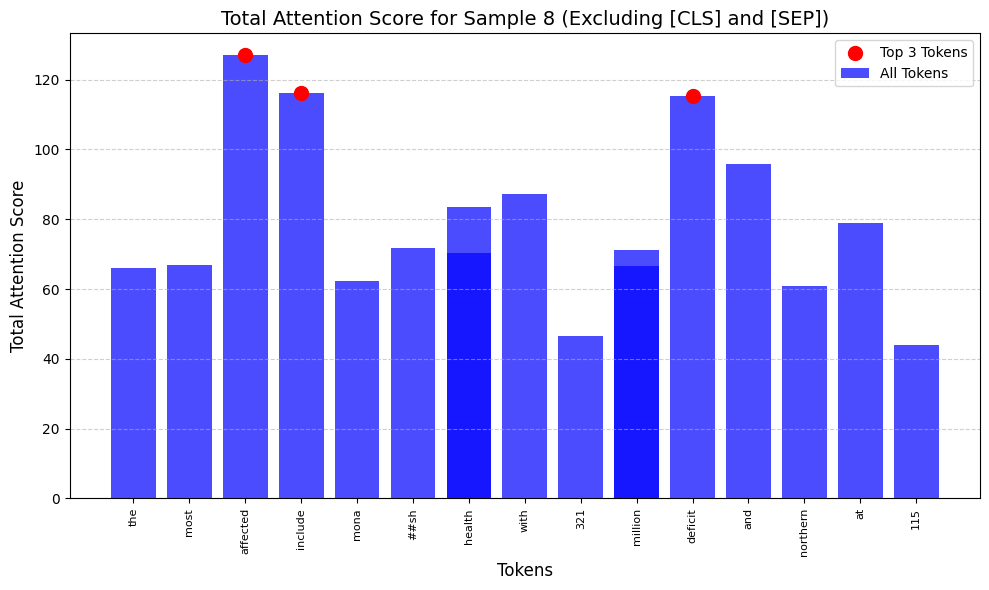

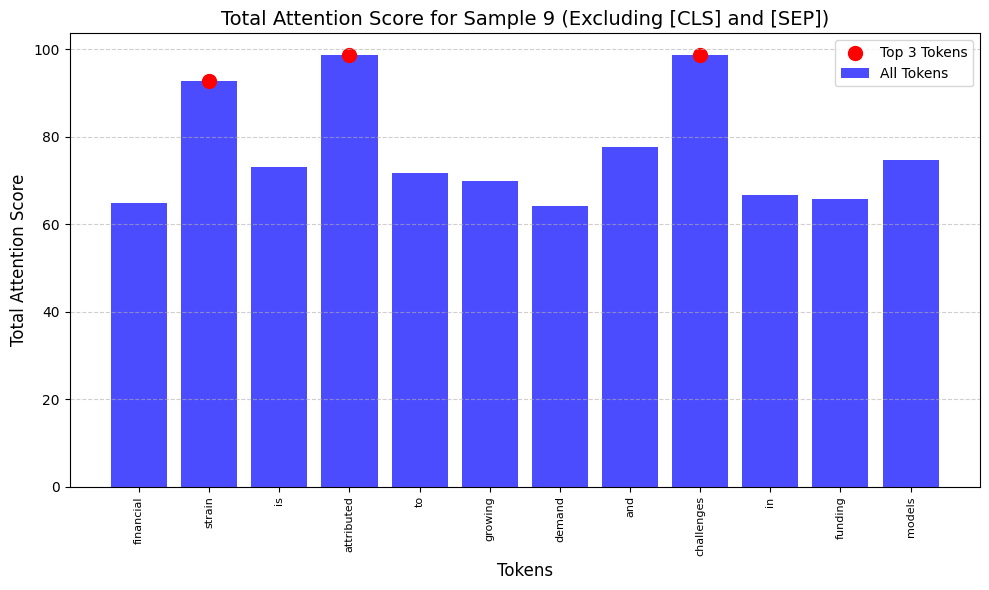

   sample_index top_token_1     score_1 top_token_2     score_2  top_token_3  \
0             0    indicted  139.306440     bribery  121.841362  prosecutors   
1             1       kenya  108.265742      wiping  101.959222       cancel   
2             2     decline  121.375572       owner  112.109817       brands   
3             3        drop  167.814020    decrease  165.598664     revealed   
4             4    financed  109.763300        left  103.680337         risk   
5             5      exceed  134.784358        drop  106.273036         loan   
6             6      citing  123.740925     ##grade  120.302903       mexico   
7             7     deficit  124.329950   recording  106.418054    hospitals   
8             8    affected  126.930670     include  116.257885      deficit   
9             9  attributed   98.665260  challenges   98.572823       strain   

      score_3  
0  114.534549  
1  101.908179  
2  105.624554  
3  141.432842  
4   96.806223  
5  103.415594  
6  112.

In [16]:
negative_results = []
for i in range(len(negative_result)):
    negative_result_row = calculate_all_attention_scores(negative_attention_matrices, i,negative_token_ids)
    negative_results.append(negative_result_row)
df_negative_results = pd.DataFrame(negative_results)
print(df_negative_results)

## Input Perturbation Based on sentiment score

In [52]:
def remove_word_and_evaluate(sentence,original_sentiment_score):
  word_list = sentence.split()
  results = {}
  for i in range(len(word_list)):
    new_sentence = ' '.join(word_list[0:i] + word_list[i+1:])
    result,_,_ = predict(new_sentence,model)
    results[word_list[i]] = {'sentiment_score':result['sentiment_score'][0],
                  'prediction' : result['prediction'][0],
                  'logit':result['logit'][0],
                  'difference':original_sentiment_score - result['sentiment_score'][0]}
  return results

#### Positive Part

In [39]:
positive_result

sentence  \
0  Shares in the spin-off of South African e-comm...   
1  There is "way more demand than is even availab...   
2  "It’s going to be an interesting hour of trade...   
3  The stock market experienced a strong rally la...   
4  Despite fluctuations among tech giants like Al...   
5  Astera Labs' stock surged following its recent...   
6  Investors are advised to capitalize on new opp...   
7  An expert report on Thyssenkrupp's steel divis...   
8  In a strong market rally, newly public Astera ...   
9  Sage Group reported a 21% increase in annual p...   

                                    logit prediction  sentiment_score  
0  [0.94383955, 0.021706667, 0.034453813]   positive         0.922133  
1    [0.9128226, 0.013744198, 0.07343315]   positive         0.899078  
2    [0.7504017, 0.023193046, 0.22640525]   positive         0.727209  
3  [0.94980687, 0.020546794, 0.029646415]   positive         0.929260  
4    [0.82901216, 0.011346785, 0.1596411]   positive         0.817665  
5    [0.9539493, 0.01751978, 0.028530987]   positive         0.936430  
6     [0.7196398, 0.15370473, 0.12665553]   positive         0.565935  
7    [0.9503253, 0.01577644, 0.033898227]   positive         0.934549  
8   [0.9534507, 0.015321126, 0.031228174]   positive         0.938130  
9  [0.95437425, 0.018573517, 0.027052145]   positive         0.935801

In [ ]:
df_positive_results =pd.DataFrame(columns = ['sentiment_score','prediction','logit','difference'])
for positive_sentence,sentiment_score in zip(positive_result['sentence'],positive_result['sentiment_score']):
  df_positive_results = pd.concat([df_positive_results,pd.DataFrame(remove_word_and_evaluate(positive_sentence,sentiment_score)).transpose()])


In [62]:
df_positive_results

sentiment_score prediction  \
Shares              0.92369   positive   
in                 0.922126   positive   
the                0.922833   positive   
spin-off           0.921319   positive   
of                 0.924829   positive   
...                     ...        ...   
to                 0.935999   positive   
significant        0.936954   positive   
rise               0.928995   positive   
its                0.935576   positive   
price.             0.936494   positive   

                                              logit difference  
Shares         [0.94218206, 0.01849228, 0.03932558]  -0.001557  
in            [0.9431523, 0.021026215, 0.035821468]   0.000007  
the           [0.94464755, 0.02181423, 0.033538174]    -0.0007  
spin-off     [0.94425005, 0.022931384, 0.032818563]   0.000814  
of             [0.9461665, 0.021337539, 0.03249601]  -0.002696  
...                                             ...        ...  
to           [0.95444113, 0.018442506, 0.027116343]  -0.000198  
significant   [0.9552064, 0.018252531, 0.026541188]  -0.001153  
rise         [0.95272905, 0.023734318, 0.023536704]   0.006806  
its            [0.9541834, 0.01860697, 0.027209632]   0.000224  
price.        [0.9549008, 0.018406589, 0.026692592]  -0.000694  

[203 rows x 4 columns]

In [63]:
df_positive_results['difference'] = pd.to_numeric(df_positive_results['difference'], errors='coerce')

# Return top 20 difference rows
top_20_difference = df_positive_results.nlargest(20, 'difference')

top_20_difference

sentiment_score prediction  \
good,"               0.068635    neutral   
as                  -0.082535   negative   
interesting          0.138042    neutral   
trade                0.366527    neutral   
Despite              0.495997   positive   
leading              0.522941   positive   
among                 0.56432   positive   
as                   0.590841   positive   
fluctuations         0.616743   positive   
emerged              0.617871   positive   
this                 0.547731   positive   
after                0.595639   positive   
opportunities        0.436105   positive   
demand               0.808406   positive   
a                    0.487714   positive   
an                    0.64914   positive   
be                   0.649485   positive   
hour                 0.667949   positive   
opening              0.678237   positive   
Astera               0.777064   positive   

                                               logit  difference  
good,"         [0.11809569, 0.049460977, 0.83244336]    0.830444  
as               [0.3786951, 0.46123058, 0.16007434]    0.648470  
interesting      [0.22252367, 0.08448123, 0.6929951]    0.589166  
trade             [0.3941972, 0.02767026, 0.5781325]    0.360682  
Despite           [0.5094254, 0.0134285, 0.47714618]    0.321669  
leading         [0.5380221, 0.015080707, 0.44689715]    0.294724  
among          [0.57850754, 0.014187782, 0.40730467]    0.253346  
as             [0.60621387, 0.015372949, 0.37841317]    0.226824  
fluctuations   [0.62949747, 0.012754396, 0.35774812]    0.200922  
emerged         [0.6349014, 0.017030187, 0.34806842]    0.199794  
this            [0.5788615, 0.031130847, 0.39000767]    0.179478  
after          [0.62117594, 0.025537405, 0.35328665]    0.131570  
opportunities      [0.6495621, 0.2134575, 0.1369804]    0.129830  
demand          [0.8194076, 0.011001786, 0.16959065]    0.090673  
a                [0.67772484, 0.1900107, 0.13226448]    0.078221  
an              [0.6717493, 0.022609377, 0.30564135]    0.078069  
be              [0.6786177, 0.029132629, 0.29224962]    0.077724  
hour           [0.73453623, 0.066587076, 0.19887663]    0.059259  
opening          [0.7092949, 0.031058239, 0.2596469]    0.048972  
Astera           [0.789358, 0.012293943, 0.19834803]    0.040601

#### Negative Part


In [64]:
negative_result

sentence  \
0  Indian billionaire Gautam Adani and his nephew...   
1  This scandal has led to a significant financia...   
2  KMD Brands, owner of Kathmandu, Rip Curl, and ...   
3  A trading update revealed a decrease in sales ...   
4  The rapid decline in used-car prices has left ...   
5  This means their loan balances exceed their ca...   
6  Moody's has downgraded Mexico's government deb...   
7  Victorian hospitals are facing a financial cri...   
8  The most affected include Monash Health with a...   
9  Financial strain is attributed to growing dema...   

                                    logit prediction  sentiment_score  
0   [0.040353637, 0.75413144, 0.20551498]   negative        -0.713778  
1   [0.01104552, 0.95773333, 0.031221097]   negative        -0.946688  
2   [0.007561856, 0.9746912, 0.017746907]   negative        -0.967129  
3  [0.0071395417, 0.9757499, 0.017110586]   negative        -0.968610  
4  [0.008658066, 0.96985406, 0.021487903]   negative        -0.961196  
5   [0.021034522, 0.9680416, 0.010923873]   negative        -0.947007  
6    [0.009929116, 0.9698387, 0.02023223]   negative        -0.959910  
7   [0.008779915, 0.9707546, 0.020465512]   negative        -0.961975  
8  [0.007951271, 0.95769864, 0.034350056]   negative        -0.949747  
9  [0.011698824, 0.94573927, 0.042561896]   negative        -0.934040

In [ ]:
df_negative_results =pd.DataFrame(columns = ['sentiment_score','prediction','logit','difference'])
for negative_sentence,sentiment_score in zip(negative_result['sentence'],negative_result['sentiment_score']):
  df_negative_results = pd.concat([df_negative_results,pd.DataFrame(remove_word_and_evaluate(negative_sentence,sentiment_score)).transpose()])


In [66]:
df_negative_results


sentiment_score prediction                                  logit  \
Indian            -0.721372   negative    [0.041953944, 0.7633263, 0.1947197]   
billionaire       -0.705192   negative  [0.042453617, 0.74764556, 0.20990081]   
Gautam            -0.721889   negative   [0.037089285, 0.7589781, 0.20393266]   
Adani             -0.710095   negative    [0.03911514, 0.7492105, 0.21167442]   
and               -0.690834   negative  [0.039287176, 0.73012114, 0.23059164]   
...                     ...        ...                                    ...   
and               -0.941187   negative  [0.010731034, 0.95191777, 0.03735123]   
challenges        -0.941468   negative  [0.009357964, 0.95082587, 0.03981621]   
in                -0.942792   negative   [0.01038131, 0.9531737, 0.036445037]   
funding           -0.924954   negative  [0.014011036, 0.9389648, 0.047024213]   
models.           -0.938589   negative  [0.012907278, 0.95149624, 0.03559636]   

            difference  
Indian        0.007595  
billionaire  -0.008586  
Gautam        0.008111  
Adani        -0.003682  
and          -0.022944  
...                ...  
and           0.007146  
challenges    0.007427  
in            0.008752  
funding      -0.009087  
models.       0.004549  

[233 rows x 4 columns]

In [68]:
df_negative_results['difference'] = pd.to_numeric(df_negative_results['difference'], errors='coerce')

# Return top 20 small difference rows
top_20_difference = df_negative_results.nsmallest(20, 'difference')

top_20_difference

sentiment_score prediction  \
affected           -0.600284   negative   
exacerbated        -0.770584   negative   
strain               -0.8172   negative   
value,             -0.861203   negative   
deficit            -0.864815   negative   
for                -0.663943   negative   
scheme             -0.679586   negative   
million            -0.680099   negative   
Financial          -0.901521   negative   
and                -0.920382   negative   
bribery            -0.685442   negative   
indicted           -0.686679   negative   
roles              -0.687438   negative   
drop               -0.922015   negative   
and                -0.690834   negative   
cancel             -0.924744   negative   
deals              -0.697511   negative   
power-supply       -0.698973   negative   
by                 -0.699227   negative   
$321                -0.93701   negative   

                                               logit  difference  
affected        [0.026838254, 0.6271222, 0.34603953]   -0.349463  
exacerbated     [0.1055006, 0.87608415, 0.018415272]   -0.176423  
strain           [0.044844624, 0.86204433, 0.093111]   -0.116841  
value,         [0.06259669, 0.92380005, 0.013603296]   -0.085804  
deficit           [0.012845066, 0.87766, 0.10949503]   -0.084932  
for             [0.046200313, 0.7101432, 0.24365646]   -0.049835  
scheme          [0.047563083, 0.7271491, 0.22528778]   -0.034192  
million         [0.042851698, 0.7229504, 0.23419791]   -0.033679  
Financial      [0.019722985, 0.9212441, 0.059032995]   -0.032519  
and            [0.009514572, 0.9298965, 0.060588982]   -0.029365  
bribery          [0.041563217, 0.727005, 0.23143174]   -0.028336  
indicted        [0.05968716, 0.74636596, 0.19394684]   -0.027099  
roles           [0.045129545, 0.7325675, 0.22230305]   -0.026340  
drop          [0.032851856, 0.95486647, 0.012281635]   -0.024992  
and            [0.039287176, 0.73012114, 0.23059164]   -0.022944  
cancel          [0.01517791, 0.93992174, 0.04490026]   -0.021944  
deals             [0.0404522, 0.7379628, 0.22158507]   -0.016267  
power-supply    [0.04257864, 0.74155176, 0.21586955]   -0.014805  
by               [0.05031614, 0.74954325, 0.2001406]   -0.014551  
$321             [0.0084806, 0.94549036, 0.04602903]   -0.012738

##Input Perturbation Based on loss

In [78]:
def calculate_loss(text, model, use_gpu=True, gpu_name='cuda:0', batch_size=1, label=1):
    model.eval()

    sentences = sent_tokenize(text)
    device = gpu_name if use_gpu and torch.cuda.is_available() else "cpu"

    # Loss function with reduction set to 'none'
    loss_fn = torch.nn.CrossEntropyLoss(reduction='none')

    losses = []

    for batch in chunks(sentences, batch_size):
        # Tokenize the batch
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=64).to(device)

        # Ground truth labels (same label for all sentences in the batch)
        labels = torch.tensor([label] * len(batch), dtype=torch.long).to(device)

        with torch.no_grad():
            model = model.to(device)
            outputs = model(**inputs)
            logits = outputs.logits  # Logits output

            # Calculate loss for each sentence
            batch_losses = loss_fn(logits, labels).cpu().numpy()
            losses.extend(batch_losses)

    return losses


In [79]:
text = positive_result['sentence'][0]
calculate_loss(text,model,label = 0)

[0.057799105]